In [1]:
import pickle 
import random
import itertools
import dataclasses

import numpy as np
from scipy import optimize

from matplotlib import pyplot as plt, rcParams, patches as mplPatches
from matplotlib.axes import Axes as mplAxes

rcParams["font.size"] = 8
rcParams["font.family"] = "Roboto Condensed"

from idpp.db.util import IdPPdb
from idpp.probability.trees import (
    DatasetQueries,
    construct_mz_trees,
    construct_ccs_tree,
    construct_rt_tree,
    construct_ms2_tree_for_adduct_ids,
    load_tree
)

# Constants

In [2]:
# search tolerances
MZ_PPMS = [0.6, 1.0, 1.8, 3.2, 5.6, 10.0, 17.8, 31.6]
CCS_PERCENTS = [0.06, 0.10, 0.18, 0.32, 0.56, 1.00, 1.78, 3.16, 5.62]
RT_TOLERANCES = {
    (186,): [0.2, 0.4, 0.8, 1.6],           # SMRT_METLIN
    (374, 375): [0.08, 0.16, 0.32, 0.64],   # ?
    (366, 367): [0.2, 0.4, 0.8, 1.6],       # ?
    (260, 261): [0.25, 0.5, 1.0, 2.0],      # ?
}
RT_TOLERANCES_EXTRA = {
    (408,): [3.2],
    (186,): [3.2],
    (374, 375): [1.28],
    (366, 367): [3.2],
    (260, 261): [4.0],
}
MS2_TOLERANCES = [0.99, 0.95, 0.9, 0.8, 0.5, 0.65, 0.25, 0.1]

In [3]:
# queries
MZ_QRY = """--sqlite3
SELECT 
    cmpd_id,
    adduct_mz
FROM 
    Adducts
    JOIN
        Compounds USING(cmpd_id)
WHERE 
    cmpd_id >= 0
    AND adduct_id >= 0
    AND adduct != "none"
    AND adduct_z {}
;"""

RT_QRY = """--sqlite3
SELECT
    cmpd_id,
    rt
FROM 
    RTs
    JOIN
        Adducts USING(adduct_id)
    JOIN
        Compounds USING(cmpd_id)
WHERE
    src_id IN ({})
;"""

CCS_QRY = """--sqlite3
SELECT
    cmpd_id,
    ccs
FROM 
    CCSs
    JOIN
        Adducts USING(adduct_id)
    JOIN
        Compounds USING(cmpd_id)
;"""

MS2_QRY_A = """--sqlite3
SELECT 
    adduct_id,
    COUNT(*) AS cnt 
FROM 
    MS2Spectra 
    JOIN 
        Adducts USING(adduct_id)
GROUP BY 
    adduct_id
;"""

MS2_QRY_B = """--sqlite3
SELECT 
    cmpd_id, 
    adduct_id,
	frag_imz, 
	SUM(frag_ii)
FROM 
    MS2Spectra 
    JOIN 
        Adducts USING(adduct_id)
    JOIN
        Compounds USING(cmpd_id)
	JOIN
		MS2Fragments USING(ms2_id)
GROUP BY 
    adduct_id, 
	frag_imz
;"""

QUERIES = DatasetQueries(
    mz_qry=(MZ_QRY.format("> 0"), MZ_QRY.format("< 0")),
    rt_qry=RT_QRY,
    ccs_qry=CCS_QRY,
    ms2_qry=(MS2_QRY_A, MS2_QRY_B)
)

# Functions

In [4]:
def fexp(x, beta, mu):
    return (1. / beta) * np.exp(-(x - mu) / beta)

def flin(x, a, b):
    return x * a + b

def fpow(x, a, b, c):
    return a * x**b + c

# m/z

## Initialize and Cache

In [5]:
db = IdPPdb("idpp_cleaned.db", read_only=True, enforce_idpp_ver=False)
mzt_pos, mzt_neg = construct_mz_trees(db, QUERIES)
print("constructed m/z tree")

print("performing m/z only queries")
mz_results = {}
mz_only_probs = {}
for ppm in MZ_PPMS: 
    print(f"{ppm=}")
    # add the results from the positive mode tree directly
    mz_results[ppm] = mzt_pos.query_all(ppm)
    # compute a separate set of results from negative mode then add them
    neg_results = mzt_neg.query_all(ppm)
    for id_neg, matches_neg in neg_results.items():
        if id_neg in mz_results[ppm]:
            mz_results[ppm][id_neg] |= matches_neg
        else:
            mz_results[ppm][id_neg] = matches_neg
    # cache results after each PPM
    with open("_cache/mz_results.pkl", "wb") as pf:
        pickle.dump(mz_results, pf)
    # get the counts
    mz_only_probs[ppm] = [len(v) for v in mz_results[ppm].values()]
    with open("_cache/mz_only_probs.pkl", "wb") as pf:
        pickle.dump(mz_only_probs, pf)

# pre-map compoud IDs to lists of adduct IDs to reduce redundant queries
cmpd_id_to_adduct_id = {
    cmpd_id: [
        adduct_id for adduct_id in db.fetch_adduct_id_by_cmpd_id(cmpd_id)
    ]
    for cmpd_id in set(
        itertools.chain.from_iterable(
            [
                mz_results[ppm].keys() 
                for ppm in MZ_PPMS
            ]
        )
    )
}
print("created compound to adduct id map")

with open("_cache/cmpd_id_to_adduct_id.pkl", "wb") as pf:
    pickle.dump(cmpd_id_to_adduct_id, pf)
print("cached compound to adduct id map")

db.close()

constructed m/z tree
performing m/z only queries
ppm=0.6
ppm=1.0
ppm=1.8
ppm=3.2
ppm=5.6
ppm=10.0
ppm=17.8
ppm=31.6
created compound to adduct id map
cached compound to adduct id map


## Load Cached

In [ ]:
with open("_cache/mz_results.pkl", "rb") as pf:
    mz_results = pickle.load(pf)

with open("_cache/mz_only_probs.pkl", "rb") as pf:
    mz_only_probs = pickle.load(pf)

with open("_cache/cmpd_id_to_adduct_id.pkl", "rb") as pf:
    cmpd_id_to_adduct_id = pickle.load(pf)

## Plots

ppm=0.6


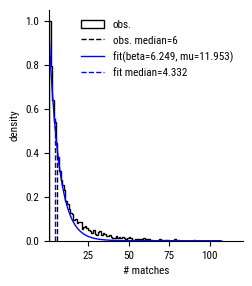

ppm=1.0


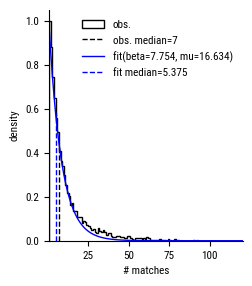

ppm=1.8


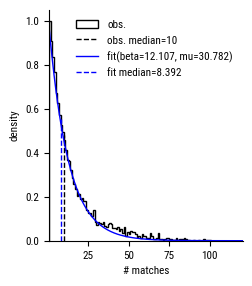

ppm=3.2


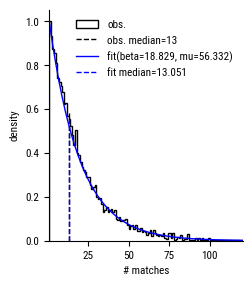

ppm=5.6


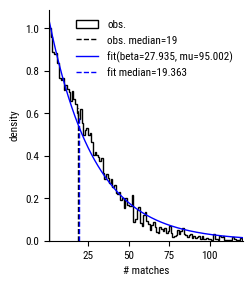

ppm=10.0


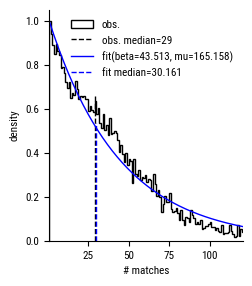

ppm=17.8


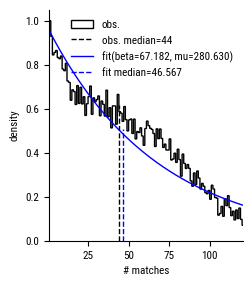

ppm=31.6


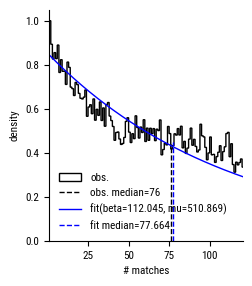

In [16]:
betas, mus, obs_meds = [], [], []
for ppm in MZ_PPMS:
    print(f"{ppm=}")
    fig, ax = plt.subplots(figsize=(2.5, 3))
    bin_max = max(mz_only_probs[ppm]) + 1
    c, x = np.histogram(mz_only_probs[ppm], np.arange(1, bin_max))
    cn = c / max(c)
    ax.hist(mz_only_probs[ppm], bins=np.arange(1, bin_max), color="k", histtype="step", lw=1., 
            weights=[1 / max(c)] * len(mz_only_probs[ppm]), label="obs.")
    obs_med = np.median(mz_only_probs[ppm])
    obs_med_y = cn[np.argmin(np.abs(x - obs_med))]
    ax.axvline(obs_med, ymax=obs_med_y, ls="--", lw=1., label=f"obs. median={obs_med:.0f}", c="k")
    (beta, mu), _ = optimize.curve_fit(fexp, x[:-1], cn)
    ax.plot(x[:-1], fexp(x[:-1], beta, mu), 'b-', lw=1., label=f"fit({beta=:.3f}, {mu=:.3f})")
    fit_med = beta * np.log(2.)
    ax.axvline(fit_med, ymax=fexp(fit_med, beta, mu), ls="--", lw=1., label=f"fit median={fit_med:.3f}", c="b")
    ax.legend(frameon=False)
    for d in ["top", "right"]:
        ax.spines[d].set_visible(False)
    #ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_xlabel("# matches")
    ax.set_ylabel("density")
    ax.set_xlim([1, 120 + 0.5])
    plt.savefig(f"_figures/mz/{ppm=}_dist_with_fit.png", dpi=400, bbox_inches="tight")
    plt.show()
    plt.close()
    betas.append(beta)
    mus.append(mu)
    obs_meds.append(obs_med)
fit_meds = [_ * np.log(2) for _ in betas]

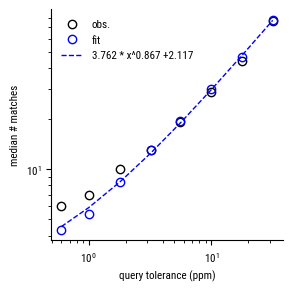

In [7]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(MZ_PPMS, obs_meds, "ko", fillstyle="none", label="obs.")
p, _ = optimize.curve_fit(fpow, MZ_PPMS, obs_meds)
#plt.plot(MZ_PPMS, flin(np.array(MZ_PPMS), *p), "k--", lw=1., label=f"power(a={p[0]:.3f}, b={p[1]:.3f})")
plt.plot(MZ_PPMS, fit_meds, "bo", fillstyle="none", label="fit")
p, _ = optimize.curve_fit(fpow, MZ_PPMS, fit_meds)
plt.plot(MZ_PPMS, fpow(np.array(MZ_PPMS), *p), "b--", lw=1., label=f"{p[0]:.3f} * x^{p[1]:.3f} {p[2]:+.3f}")
ax.legend(frameon=False)
ax.set_xscale("log")
ax.set_yscale("log")
for d in ["top", "right"]:
    ax.spines[d].set_visible(False)
ax.set_xlabel("query tolerance (ppm)")
ax.set_ylabel("median # matches")
plt.savefig("_figures/mz/medians_obs_fit_vs_tol.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

# m/z + CCS

## Initialize and Cache

In [8]:
db = IdPPdb("idpp_cleaned.db", read_only=True, enforce_idpp_ver=False)
ccst = construct_ccs_tree(db, QUERIES)

mz_ccs_probs = {}
for ppm in MZ_PPMS:
    for percent in CCS_PERCENTS:
        counts = []
        for id_A, matched_A in mz_results[ppm].items():
            # id_A is a compound ID, need to convert to adduct ID(s) then use that(those)
            # to fetch CCS values to query the CcsTree with
            # treat each set of adduct CCS values as a separate addition to the counts list
            for add_id_A in cmpd_id_to_adduct_id[id_A]:
                # fetch CCS values (if any) then average them and query
                if len(ccss := [_[1] for _ in db.fetch_ccs_by_adduct_id(add_id_A)]) > 0:
                    matched_B = ccst.query_radius_single(np.mean(ccss), percent)
                    counts.append(len(matched_A & matched_B))
        if len(counts) > 0:
            mz_ccs_probs[(ppm, percent)] = counts
print("created m/z + CCS query results")

with open("_cache/mz_ccs_probs.pkl", "wb") as pf:
    pickle.dump(mz_ccs_probs, pf)
print("cached m/z + CCS query results")

db.close()

constructing property trees ...
    CcsTree ... ok
created m/z + CCS query results
cached m/z + CCS query results


## Load Cached

In [ ]:
with open("_cache/mz_ccs_probs.pkl", "rb") as pf:
    mz_ccs_probs = pickle.load(pf)

## Plots

ppm=0.6 percent=0.06


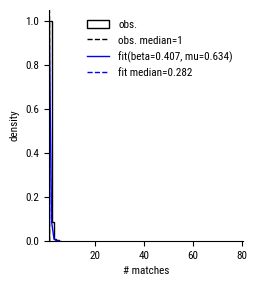

ppm=0.6 percent=0.1


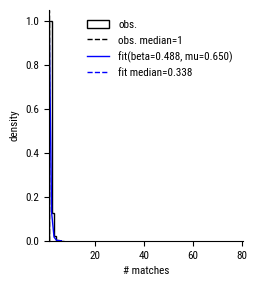

ppm=0.6 percent=0.18


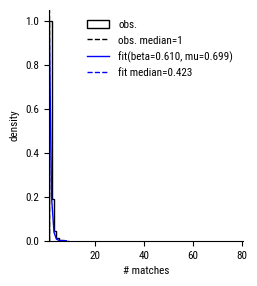

ppm=0.6 percent=0.32


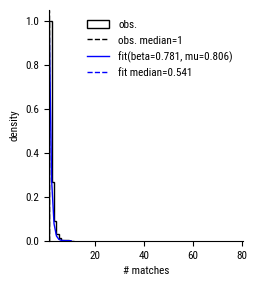

ppm=0.6 percent=0.56


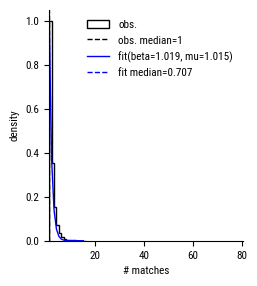

ppm=0.6 percent=1.0


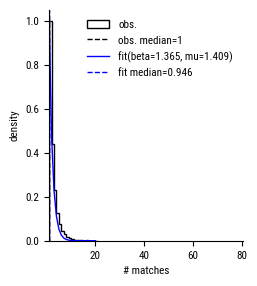

ppm=0.6 percent=1.78


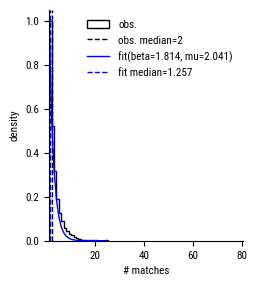

ppm=0.6 percent=3.16


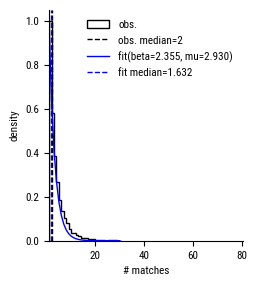

ppm=0.6 percent=5.62


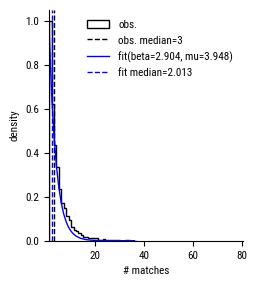

ppm=1.0 percent=0.06


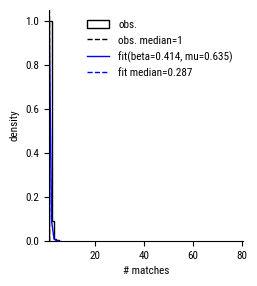

ppm=1.0 percent=0.1


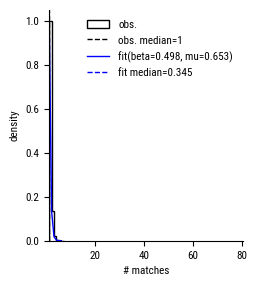

ppm=1.0 percent=0.18


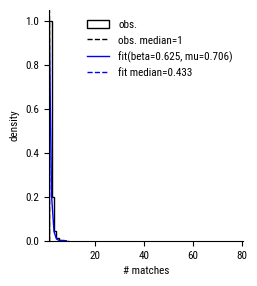

ppm=1.0 percent=0.32


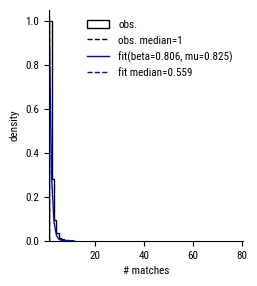

ppm=1.0 percent=0.56


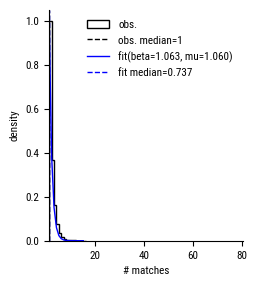

ppm=1.0 percent=1.0


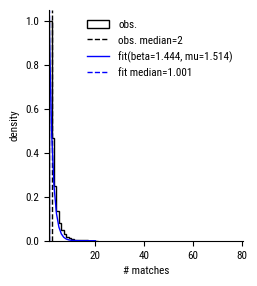

ppm=1.0 percent=1.78


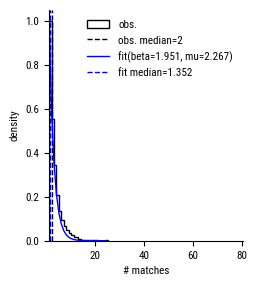

ppm=1.0 percent=3.16


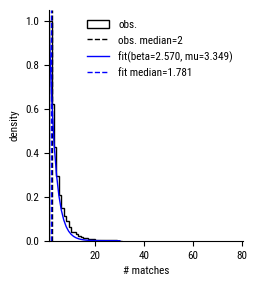

ppm=1.0 percent=5.62


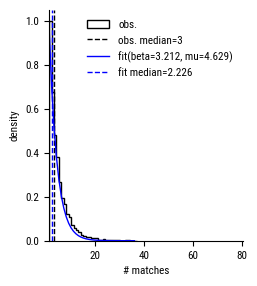

ppm=1.8 percent=0.06


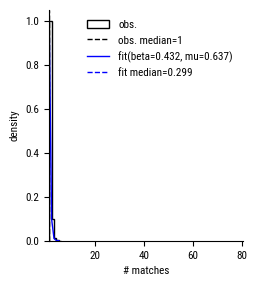

ppm=1.8 percent=0.1


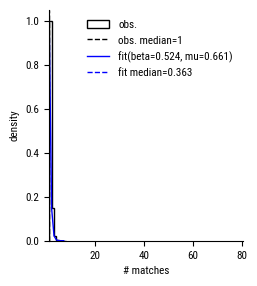

ppm=1.8 percent=0.18


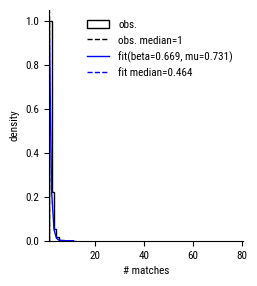

ppm=1.8 percent=0.32


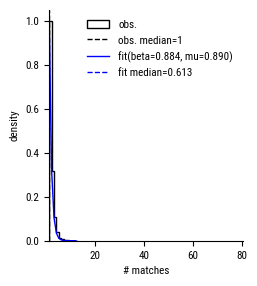

ppm=1.8 percent=0.56


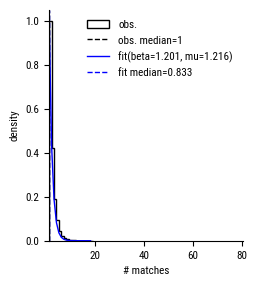

ppm=1.8 percent=1.0


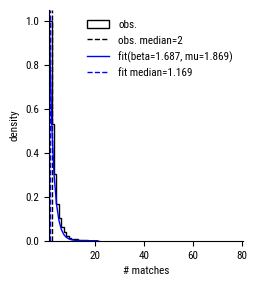

ppm=1.8 percent=1.78


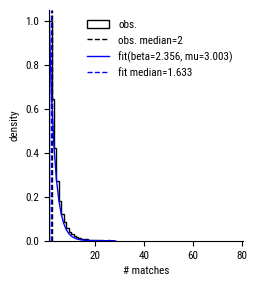

ppm=1.8 percent=3.16


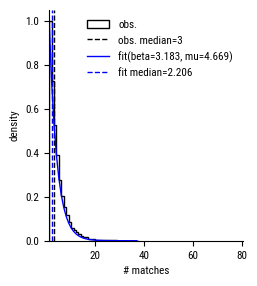

ppm=1.8 percent=5.62


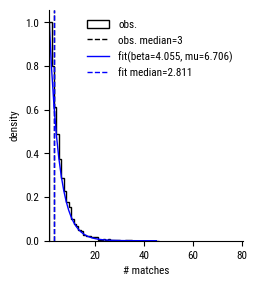

ppm=3.2 percent=0.06


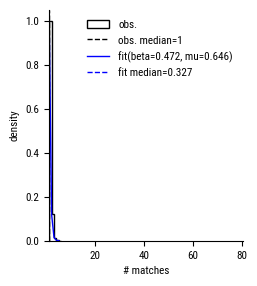

ppm=3.2 percent=0.1


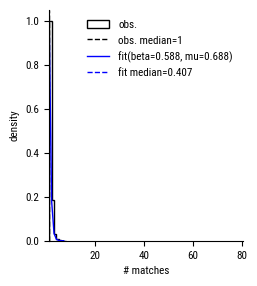

ppm=3.2 percent=0.18


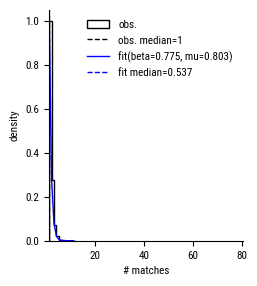

ppm=3.2 percent=0.32


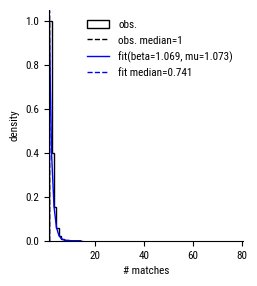

ppm=3.2 percent=0.56


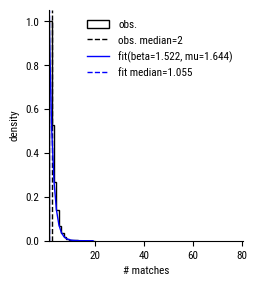

ppm=3.2 percent=1.0


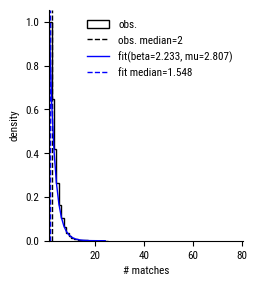

ppm=3.2 percent=1.78


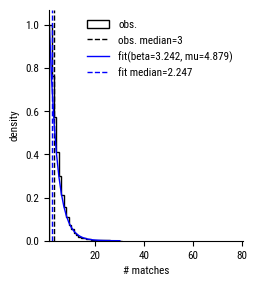

ppm=3.2 percent=3.16


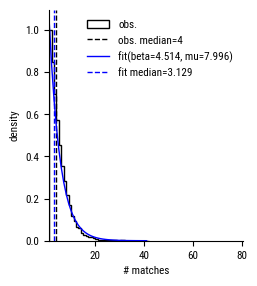

ppm=3.2 percent=5.62


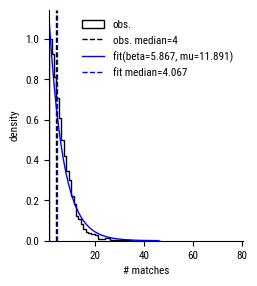

ppm=5.6 percent=0.06


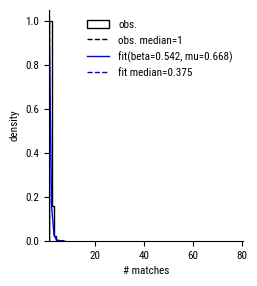

ppm=5.6 percent=0.1


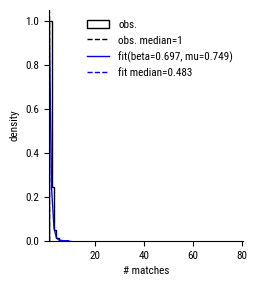

ppm=5.6 percent=0.18


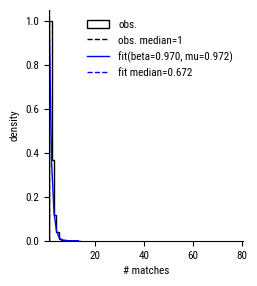

ppm=5.6 percent=0.32


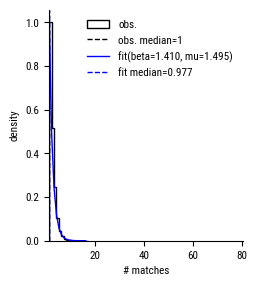

ppm=5.6 percent=0.56


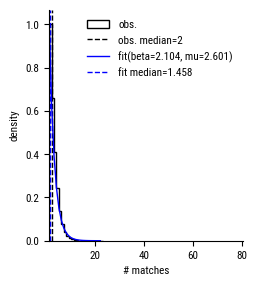

ppm=5.6 percent=1.0


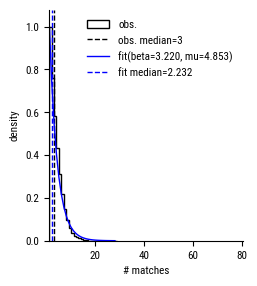

ppm=5.6 percent=1.78


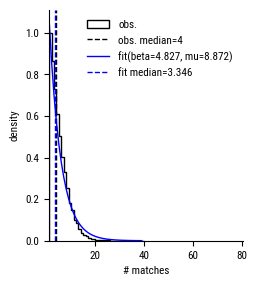

ppm=5.6 percent=3.16


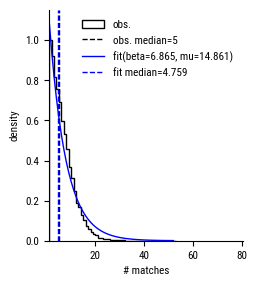

ppm=5.6 percent=5.62


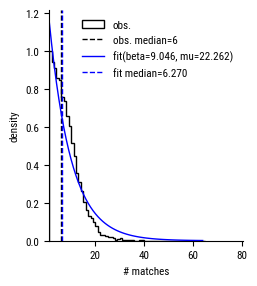

ppm=10.0 percent=0.06


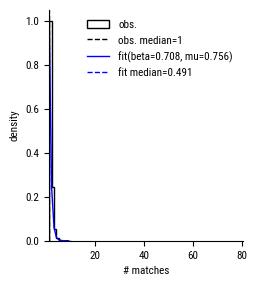

ppm=10.0 percent=0.1


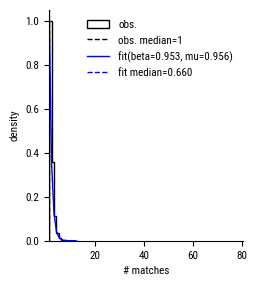

ppm=10.0 percent=0.18


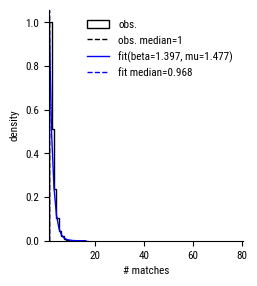

ppm=10.0 percent=0.32


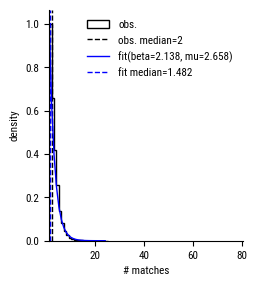

ppm=10.0 percent=0.56


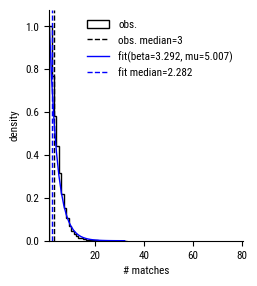

ppm=10.0 percent=1.0


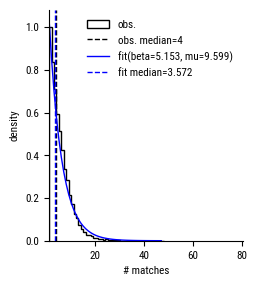

ppm=10.0 percent=1.78


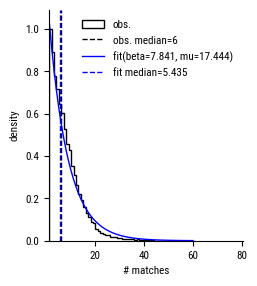

ppm=10.0 percent=3.16


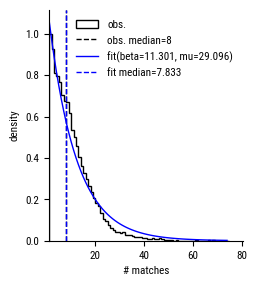

ppm=10.0 percent=5.62


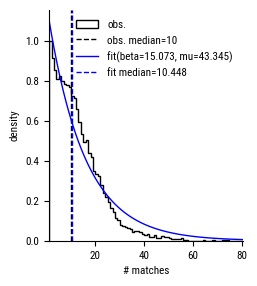

ppm=17.8 percent=0.06


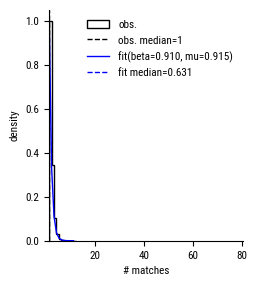

ppm=17.8 percent=0.1


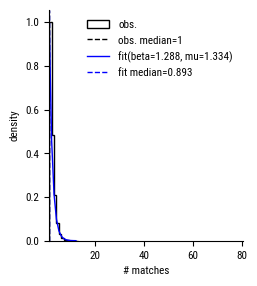

ppm=17.8 percent=0.18


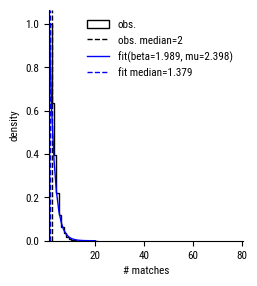

ppm=17.8 percent=0.32


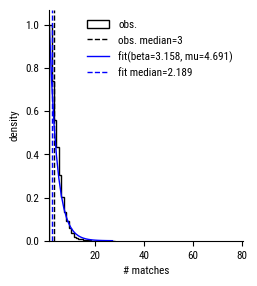

ppm=17.8 percent=0.56


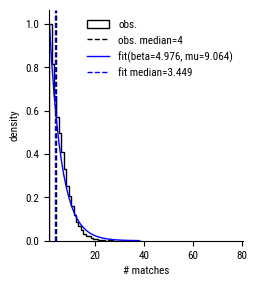

ppm=17.8 percent=1.0


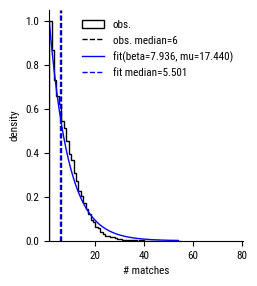

ppm=17.8 percent=1.78


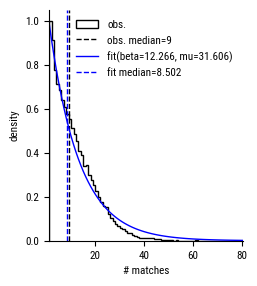

ppm=17.8 percent=3.16


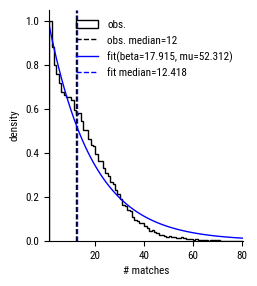

ppm=17.8 percent=5.62


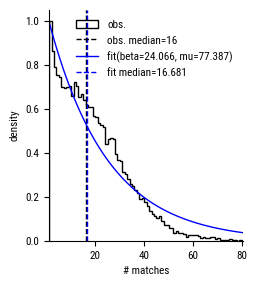

ppm=31.6 percent=0.06


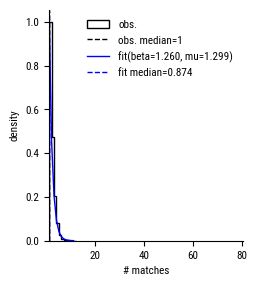

ppm=31.6 percent=0.1


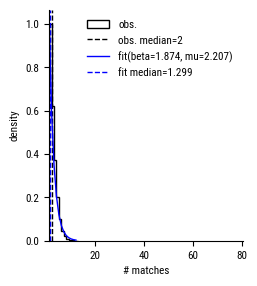

ppm=31.6 percent=0.18


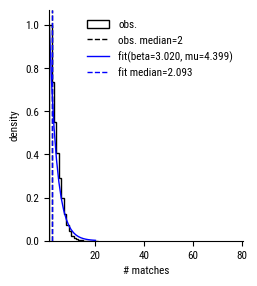

ppm=31.6 percent=0.32


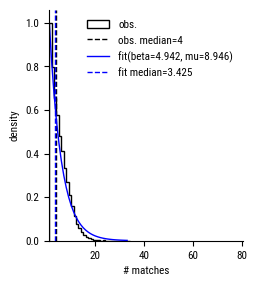

ppm=31.6 percent=0.56


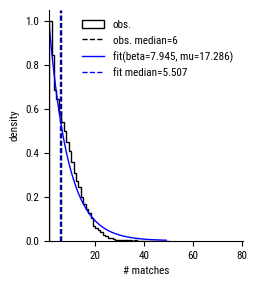

ppm=31.6 percent=1.0


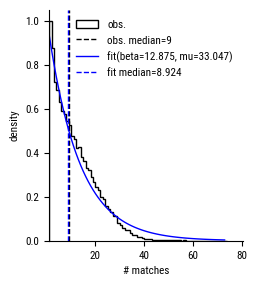

ppm=31.6 percent=1.78


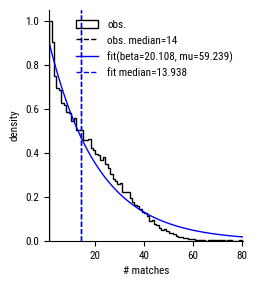

ppm=31.6 percent=3.16


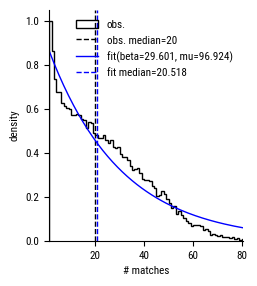

ppm=31.6 percent=5.62


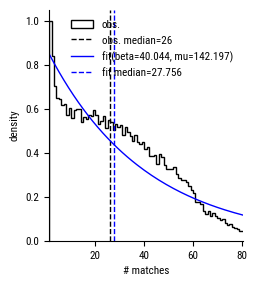

In [14]:
# keep track of fit parameters and summary stats
ppms, percents = [], []
betas, mus, obs_meds = [], [], []
for ppm in MZ_PPMS:
    for percent in CCS_PERCENTS:
        ppms.append(ppm)
        percents.append(percent)
        print(f"{ppm=} {percent=}")
        fig, ax = plt.subplots(figsize=(2.5, 3))
        bin_max = max(mz_ccs_probs[(ppm, percent)]) + 1
        c, x = np.histogram(mz_ccs_probs[(ppm, percent)], np.arange(1, bin_max))
        cn = c / max(c)
        ax.hist(mz_ccs_probs[(ppm, percent)], bins=np.arange(1, bin_max), color="k", histtype="step", lw=1., 
                weights=[1 / max(c)] * len(mz_ccs_probs[(ppm, percent)]), label="obs.") 
        obs_med = np.median(mz_ccs_probs[(ppm, percent)])
        ax.axvline(obs_med, ls="--", lw=1., label=f"obs. median={obs_med:.0f}", c="k")
        (beta, mu), _ = optimize.curve_fit(fexp, x[:-1], cn)
        ax.plot(x[:-1], fexp(x[:-1], beta, mu), 'b-', lw=1., label=f"fit({beta=:.3f}, {mu=:.3f})")
        fit_med = beta * np.log(2.)
        ax.axvline(fit_med, ls="--", lw=1., label=f"fit median={fit_med:.3f}", c="b")
        ax.legend(frameon=False)
        for d in ["top", "right"]:
            ax.spines[d].set_visible(False)
        #ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax.set_xlabel("# matches")
        ax.set_ylabel("density")
        ax.set_xlim([1, 80 + 0.5])
        plt.savefig(f"_figures/mz_ccs/{ppm=}_{percent=}_dist_with_fit.png", dpi=400, bbox_inches="tight")
        plt.show()
        plt.close()
        betas.append(beta)
        mus.append(mu)
        obs_meds.append(obs_med)
fit_meds = [_ * np.log(2) for _ in betas]

/var/folders/93/rxb_7lxj5dnfzlgq40hwpl254g3nd8/T/ipykernel_86913/1689061305.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  cb = fig.colorbar(tcf, cax=axcb)


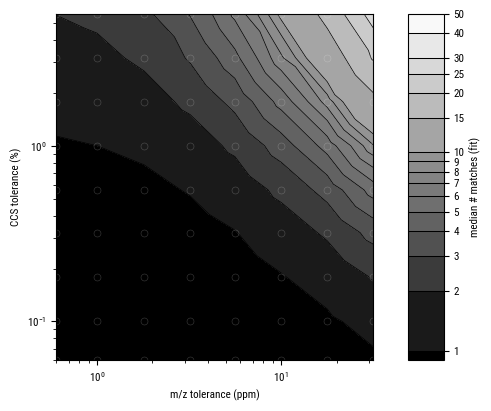

In [15]:
fig, (ax, axcb) = plt.subplots(ncols=2, width_ratios=(9, 1), figsize=(5, 4.5))
mz_bins = MZ_PPMS + [56]
ccs_bins = CCS_PERCENTS + [10]
levels = [_ for _ in range(11)] + [15, 20, 25, 30, 40, 50]
tcf = ax.tricontourf(ppms, percents, fit_meds, levels, cmap="binary_r", norm="log")
ax.tricontour(ppms, percents, fit_meds, levels, colors="k", linewidths=0.5)
ax.plot(ppms, percents, "wo", ms=5, fillstyle="none", mew=0.5, alpha=0.2)
ax.set_xlabel("m/z tolerance (ppm)")
ax.set_ylabel("CCS tolerance (%)")
ax.set_xscale("log")
ax.set_yscale("log")
cb = fig.colorbar(tcf, cax=axcb)
cb.set_ticks(levels[1:])
cb.set_ticklabels(levels[1:])
for l in levels[1:-1]:
    cb.ax.axhline(l, lw=0.75, c="k")
cb.set_label("median # matches (fit)")
plt.savefig("_figures/mz_ccs/2D_tolerance_contour.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [35]:
len(mz_only_probs[1.0])

165923

In [34]:
len(mz_ccs_probs[(10.0, 1.0)])

68419

# m/z + RT

## Initialize and Cache

In [17]:
db = IdPPdb("idpp_cleaned.db", read_only=True, enforce_idpp_ver=False)

In [18]:
for src_ids in RT_TOLERANCES.keys():
    qrs = dataclasses.replace(QUERIES)
    qrs.rt_qry = qrs.rt_qry.format(",".join([str(_) for _ in src_ids]))
    rtt = construct_rt_tree(db, qrs)
    rtt.save("_cache", ".".join([str(_) for _ in src_ids]))

constructing property trees ...
    RtTree ... ok
constructing property trees ...
    RtTree ... ok
constructing property trees ...
    RtTree ... ok
constructing property trees ...
    RtTree ... ok


In [19]:
# load pre-made RT trees
rtt = {
    src_ids: load_tree(f"_cache/RtTree_dsid={".".join([str(_) for _ in src_ids])}.pkl")
    for src_ids in RT_TOLERANCES.keys()
}

In [20]:
mz_rt = {}

In [21]:
for i in range(3):
    random.seed(i + 100)
    for ppm in MZ_PPMS:
        print(f"{ppm=}")
        selected = 0
        for i, (id_A, matched_A) in enumerate(mz_results[ppm].items()):
            if random.random() > 0.1:  # sample 10%
                # most of the time just skip
                continue
            selected += 1
            try:
                # id_A is a compound ID
                # because this is RT and it does not really matter what the adduct is, search directly using the 
                # compound ID
                # treat each set of adduct RT values as a separate addition to the counts list
                #print(f"{id_A=} {matched_A=}")
                for src_ids, tols in RT_TOLERANCES.items():
                    #print(f"{src_ids=}")
                    for (_, rt) in db.fetch_rt_by_cmpd_id(id_A, select_sources=list(src_ids)):
                        #print(f"rt_id={_} {rt=:.2f}")
                        for tol in tols:
                            matched_B = rtt[src_ids].query_radius_single(rt, tol)
                            common = matched_A & matched_B
                            n = len(common)
                            k = (ppm, tol)
                            k += src_ids
                            if k in mz_rt:
                                mz_rt[k].append(n)
                            else:
                                mz_rt[k] = [n]
                print(f"\rsampled {selected} of {i + 1}  ({100 * (selected / (i + 1)):.1f} %)", end="    ")
            except KeyboardInterrupt:
                break
            except Exception as e:
                print("Exception:", e)
                continue
            #print("---")
        # cache the results after each ppm completes
        with open("_cache/mz_rt.pkl", "wb") as pf:
            pickle.dump(mz_rt, pf)
    print()

ppm=0.6
sampled 16499 of 165918  (9.9 %)    ppm=1.0
sampled 16472 of 165922  (9.9 %)    ppm=1.8
sampled 16497 of 165921  (9.9 %)    ppm=3.2
sampled 16600 of 165921  (10.0 %)    ppm=5.6
sampled 16646 of 165916  (10.0 %)    ppm=10.0
sampled 16436 of 165881  (9.9 %)     ppm=17.8
sampled 16641 of 165923  (10.0 %)    ppm=31.6
sampled 16581 of 165916  (10.0 %)    
ppm=0.6
sampled 16618 of 165898  (10.0 %)    ppm=1.0
sampled 16575 of 165922  (10.0 %)    ppm=1.8
sampled 16632 of 165909  (10.0 %)    ppm=3.2
sampled 16502 of 165919  (9.9 %)     ppm=5.6
sampled 16797 of 165910  (10.1 %)    ppm=10.0
sampled 16722 of 165906  (10.1 %)    ppm=17.8
sampled 16629 of 165923  (10.0 %)    ppm=31.6
sampled 16690 of 165917  (10.1 %)    
ppm=0.6
sampled 16475 of 165923  (9.9 %)    ppm=1.0
sampled 16551 of 165903  (10.0 %)    ppm=1.8
sampled 16784 of 165922  (10.1 %)    ppm=3.2
sampled 16661 of 165923  (10.0 %)    ppm=5.6
sampled 16619 of 165909  (10.0 %)    ppm=10.0
sampled 16429 of 165922  (9.9 %)    ppm=17

In [ ]:
db.close()

In [42]:
np.mean([len(mz_rt_probs[(186,)][(_mzt, _rtt)]) for _mzt in MZ_PPMS for _rtt in RT_TOLERANCES[(186,)]])

23984.625

## Load Cached

In [ ]:
with open("_cache/mz_rt.pkl", "rb") as pf:
    mz_rt_probs = pickle.load(pf)

## Plots

In [22]:
# unpack and combine the mz rt query results
mz_rt_probs = {
    src_ids: {}
    for src_ids in RT_TOLERANCES.keys()
}
for (ppm, tol, *src_ids), counts  in mz_rt.items():
    mz_rt_probs[tuple(src_ids)][(ppm, tol)] = counts

src_ids=(186,)
ppm=0.6 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[1.00000000e+00 4.28061548e-01 2.01380076e-01 1.05885152e-01
 6.78140863e-02 3.42639594e-02 2.31598985e-02 1.26110406e-02
 1.06281726e-02 4.36230964e-03 2.61738579e-03 9.51776650e-04
 1.58629442e-04 2.37944162e-04 4.75888325e-04 1.58629442e-04]


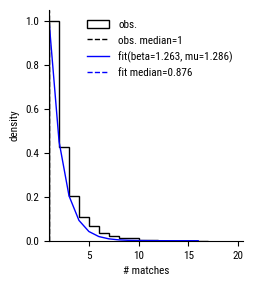

ppm=0.6 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[1.00000000e+00 5.44725738e-01 3.22573840e-01 1.99683544e-01
 1.29430380e-01 9.15611814e-02 6.22362869e-02 4.69409283e-02
 3.44936709e-02 2.55274262e-02 1.81434599e-02 1.18143460e-02
 7.70042194e-03 6.43459916e-03 3.90295359e-03 3.69198312e-03
 3.79746835e-03 8.43881857e-04 1.37130802e-03 1.37130802e-03
 6.32911392e-04 1.05485232e-04 1.05485232e-04 2.10970464e-04]


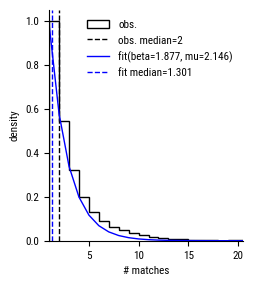

ppm=0.6 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]
[1.00000000e+00 6.21139626e-01 4.18877773e-01 3.11584747e-01
 2.40104393e-01 1.70363926e-01 1.27881688e-01 1.13237640e-01
 8.88792229e-02 6.72756271e-02 5.20516166e-02 4.10323329e-02
 3.62476439e-02 3.23328984e-02 2.92880963e-02 2.20385675e-02
 1.37741047e-02 1.39190953e-02 1.13092649e-02 8.69943454e-03
 8.26446281e-03 5.36465130e-03 5.36465130e-03 5.07467015e-03
 4.92967957e-03 2.46483979e-03 3.18979266e-03 7.24952878e-04
 5.79962302e-04 1.30491518e-03 1.44990576e-04 5.79962302e-04
 4.34971727e-04 1.44990576e-04 5.79962302e-04 8.69943454e-04]


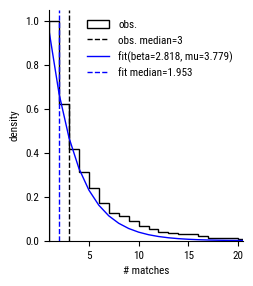

ppm=0.6 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]
[1.00000000e+00 6.89524190e-01 4.99800080e-01 3.94442223e-01
 3.17073171e-01 2.77688924e-01 2.06317473e-01 1.85525790e-01
 1.46141543e-01 1.36545382e-01 1.11155538e-01 1.02558976e-01
 8.43662535e-02 8.15673731e-02 6.35745702e-02 5.29788085e-02
 4.47820872e-02 4.01839264e-02 3.33866453e-02 3.85845662e-02
 3.49860056e-02 3.29868053e-02 2.77888844e-02 1.71931228e-02
 1.99920032e-02 1.79928029e-02 1.69932027e-02 1.13954418e-02
 8.99640144e-03 7.59696122e-03 7.59696122e-03 5.39784086e-03
 7.99680128e-03 7.59696122e-03 5.59776090e-03 5.99760096e-03
 7.19712115e-03 2.79888045e-03 2.59896042e-03 2.59896042e-03
 2.19912035e-03 2.99880048e-03 2.99880048e-03 5.99760096e-04
 5.99760096e-04 0.00000000e+00 9.99600160e-04 5.99760096e-04
 7.99680128e-04 3.99840064e-04 5.99760096e-04 1.99920032e-04
 0.00000000e+00 3.9984006

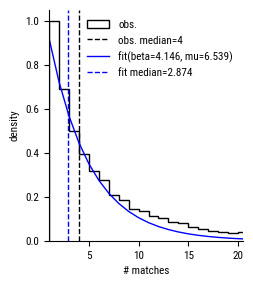

ppm=1.0 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 4.35913756e-01 2.10995306e-01 1.04781606e-01
 6.60354841e-02 3.51658843e-02 2.09244968e-02 1.25706102e-02
 9.54729891e-03 4.45540616e-03 3.50067627e-03 2.06858143e-03
 3.97804121e-04 7.95608243e-05 5.56925770e-04 1.59121649e-04
 3.97804121e-04]


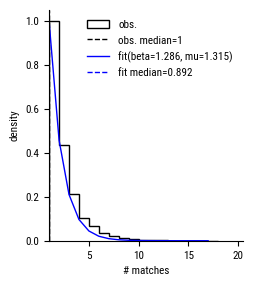

ppm=1.0 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 5.47644425e-01 3.41611597e-01 2.07844809e-01
 1.28224259e-01 9.82732893e-02 6.80025581e-02 4.48731614e-02
 3.56000853e-02 2.34491580e-02 1.54551268e-02 1.08718823e-02
 5.96887657e-03 5.22276700e-03 6.60839906e-03 4.26348327e-03
 4.15689618e-03 1.81198039e-03 2.34491580e-03 1.38563206e-03
 9.59283735e-04 2.13174163e-04 3.19761245e-04 2.13174163e-04
 2.13174163e-04]


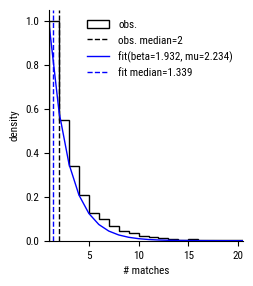

ppm=1.0 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[1.00000000e+00 6.29902684e-01 4.47508110e-01 3.14066647e-01
 2.44618107e-01 1.76791507e-01 1.45974639e-01 1.14420525e-01
 9.30404011e-02 6.69419050e-02 5.24918903e-02 4.83633147e-02
 3.25862577e-02 3.11117664e-02 2.58035978e-02 1.85785904e-02
 1.12061339e-02 1.19433795e-02 1.43025656e-02 9.43674432e-03
 1.28280743e-02 5.30816868e-03 4.57092303e-03 4.86582129e-03
 3.98112651e-03 2.21173695e-03 2.65408434e-03 1.03214391e-03
 1.76938956e-03 2.80153347e-03 5.89796520e-04 8.84694780e-04
 5.89796520e-04 5.89796520e-04 2.94898260e-04 7.37245650e-04
 1.47449130e-04 1.47449130e-04 1.47449130e-04]


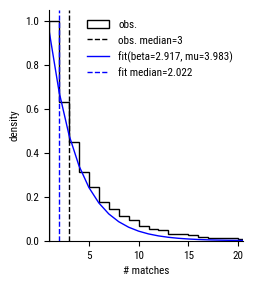

ppm=1.0 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51]
[1.00000000e+00 6.79935012e-01 5.24979691e-01 3.93582453e-01
 3.46263201e-01 2.65231519e-01 2.32940699e-01 1.95572705e-01
 1.64906580e-01 1.41551584e-01 1.13931763e-01 1.02965069e-01
 8.22502031e-02 7.65637693e-02 7.14865963e-02 5.56458164e-02
 5.44272949e-02 3.73679935e-02 3.26969943e-02 3.67587327e-02
 3.49309504e-02 3.02599513e-02 2.27457352e-02 1.92932575e-02
 1.96994314e-02 1.62469537e-02 1.58407799e-02 1.13728676e-02
 7.92038993e-03 1.13728676e-02 8.93582453e-03 5.68643379e-03
 7.71730301e-03 6.70186840e-03 4.67099919e-03 4.67099919e-03
 6.90495532e-03 3.04630382e-03 2.84321690e-03 2.64012998e-03
 2.43704305e-03 3.45247766e-03 2.64012998e-03 1.01543461e-03
 1.82778229e-03 2.03086921e-04 6.09260764e-04 2.03086921e-04
 1.01543461e-03 1.21852153e-03 2.03086921e-03]


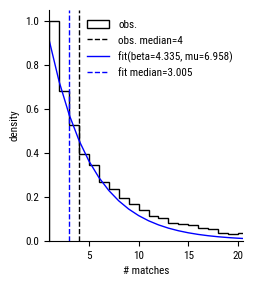

ppm=1.8 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 4.37748766e-01 2.14297086e-01 1.07546569e-01
 6.55946505e-02 3.53446903e-02 2.27670753e-02 1.25776150e-02
 1.06670912e-02 4.69670435e-03 2.70657539e-03 8.75656743e-04
 4.77630950e-04 7.96051584e-05 6.36841267e-04 1.59210317e-04
 7.96051584e-05]


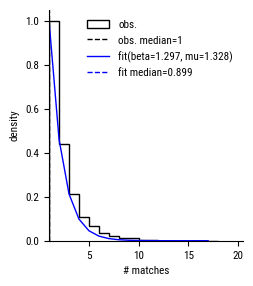

ppm=1.8 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 5.59012187e-01 3.42527261e-01 2.09749840e-01
 1.33418858e-01 9.52533675e-02 6.97028009e-02 4.61834509e-02
 3.27132777e-02 2.57643789e-02 1.61428266e-02 1.13320505e-02
 6.84199273e-03 7.16271114e-03 5.55911909e-03 3.84862091e-03
 2.88646568e-03 1.28287364e-03 2.24502886e-03 9.62155228e-04
 4.27624546e-04 1.06906136e-04 2.13812273e-04 0.00000000e+00
 1.06906136e-04]


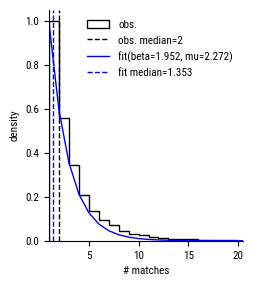

ppm=1.8 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[1.00000000e+00 6.30980508e-01 4.55847608e-01 3.22504430e-01
 2.46751329e-01 1.77347903e-01 1.41907856e-01 1.19019492e-01
 9.09627880e-02 6.67454223e-02 5.41937389e-02 3.72120496e-02
 3.78027171e-02 3.55877141e-02 2.46603662e-02 2.33313644e-02
 1.29946840e-02 1.71293562e-02 1.04843473e-02 9.45067927e-03
 1.10750148e-02 4.13467218e-03 3.10100413e-03 4.43000591e-03
 4.43000591e-03 2.95333727e-03 2.36266982e-03 1.18133491e-03
 1.32900177e-03 1.32900177e-03 5.90667454e-04 7.38334318e-04
 2.95333727e-04 4.43000591e-04 1.47666864e-04 7.38334318e-04
 1.47666864e-04 1.47666864e-04 1.47666864e-04]


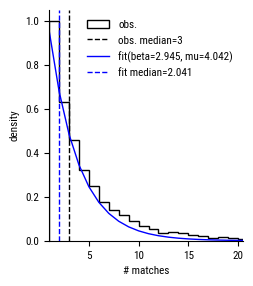

ppm=1.8 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
[1.00000000e+00 7.01963241e-01 5.42606516e-01 4.22514620e-01
 3.52756892e-01 2.86131997e-01 2.52088555e-01 1.96741855e-01
 1.67293233e-01 1.56641604e-01 1.15079365e-01 1.02548037e-01
 9.08521303e-02 7.33082707e-02 7.28905597e-02 5.51378446e-02
 4.36507937e-02 4.61570593e-02 3.63408521e-02 4.44862155e-02
 3.78028404e-02 3.13283208e-02 2.33918129e-02 1.58730159e-02
 1.98412698e-02 2.04678363e-02 1.75438596e-02 1.16959064e-02
 1.21136174e-02 1.10693400e-02 6.47451963e-03 6.26566416e-03
 7.51879699e-03 6.68337510e-03 5.01253133e-03 4.17710944e-03
 5.01253133e-03 3.13283208e-03 5.01253133e-03 1.46198830e-03
 1.46198830e-03 2.92397661e-03 2.50626566e-03 4.17710944e-04
 1.46198830e-03 1.04427736e-03 4.17710944e-04 6.26566416e-04
 2.92397661e-03 4.17710944e-04 1.25313283e-03 0.00000000e+00
 2.08855472e-04 4.1771

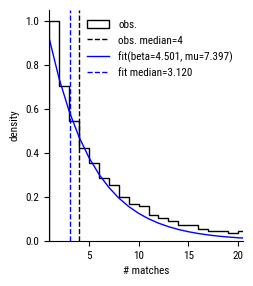

ppm=3.2 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 4.65600533e-01 2.39213726e-01 1.18690655e-01
 7.37964351e-02 4.04797601e-02 2.66533400e-02 1.54089622e-02
 1.08279194e-02 5.66383475e-03 3.33166750e-03 9.99500250e-04
 8.32916875e-04 1.66583375e-04 7.49625187e-04 2.49875062e-04
 2.49875062e-04]


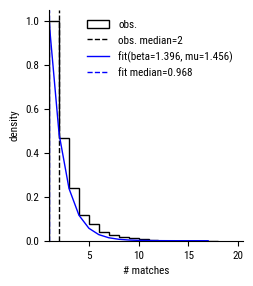

ppm=3.2 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 6.00068894e-01 3.82477896e-01 2.33207027e-01
 1.50993225e-01 1.14019979e-01 7.88839132e-02 5.51153979e-02
 4.19106671e-02 3.13468825e-02 2.17016879e-02 1.38936732e-02
 9.18589964e-03 8.03766219e-03 6.54495350e-03 5.05224480e-03
 3.55953611e-03 1.14823746e-03 1.95200367e-03 1.03341371e-03
 3.44471237e-04 0.00000000e+00 2.29647491e-04 3.44471237e-04
 1.14823746e-04]


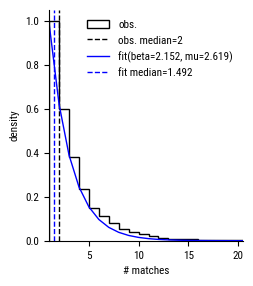

ppm=3.2 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[1.00000000e+00 6.80780681e-01 5.10420112e-01 3.74958650e-01
 2.95567317e-01 2.18326166e-01 1.73503143e-01 1.46212372e-01
 1.13628846e-01 8.48494873e-02 7.19483956e-02 5.21005624e-02
 4.56500165e-02 3.80416804e-02 3.44029110e-02 2.76215680e-02
 1.37280847e-02 1.98478333e-02 1.75322527e-02 9.75851803e-03
 1.19087000e-02 6.45054582e-03 6.45054582e-03 5.12735693e-03
 4.79655971e-03 4.13496527e-03 2.81177638e-03 9.92391664e-04
 4.96195832e-04 2.15018194e-03 3.30797221e-04 6.61594443e-04
 9.92391664e-04 4.96195832e-04 0.00000000e+00 3.30797221e-04
 1.65398611e-04 1.65398611e-04]


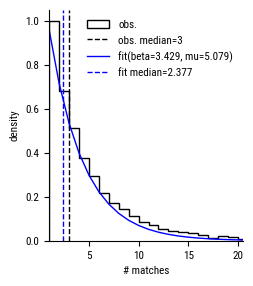

ppm=3.2 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
[1.00000000e+00 7.63061074e-01 6.22026000e-01 5.04782929e-01
 4.29973019e-01 3.51974491e-01 2.98503802e-01 2.66862889e-01
 2.08241354e-01 1.94015207e-01 1.61393181e-01 1.41035075e-01
 1.22884474e-01 1.02281089e-01 8.85454991e-02 6.27912681e-02
 7.06401766e-02 5.64140299e-02 4.56217807e-02 5.54329164e-02
 4.56217807e-02 3.55653667e-02 3.55653667e-02 2.59995094e-02
 2.79617366e-02 2.45278391e-02 2.84522934e-02 1.74147658e-02
 1.29997547e-02 1.32450331e-02 1.00564140e-02 9.56585725e-03
 1.00564140e-02 9.81113564e-03 6.13195977e-03 4.66028943e-03
 5.15084621e-03 3.43389747e-03 3.92445426e-03 2.94334069e-03
 2.94334069e-03 3.92445426e-03 1.96222713e-03 0.00000000e+00
 2.94334069e-03 2.45278391e-04 9.81113564e-04 7.35835173e-04
 1.96222713e-03 2.45278391e-04 2.20750552e-03 2.45278391e-04
 0.00000000e+00 0.0000

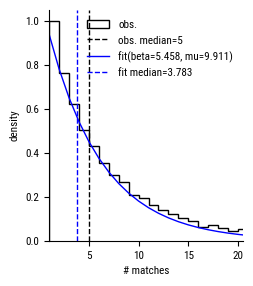

ppm=5.6 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 5.25348942e-01 2.86447546e-01 1.54524989e-01
 9.46420531e-02 5.02476362e-02 3.39486718e-02 1.63890140e-02
 1.16163890e-02 6.12336785e-03 3.42188204e-03 1.44079244e-03
 8.10445745e-04 3.60198109e-04 7.20396218e-04 3.60198109e-04
 9.00495272e-05]


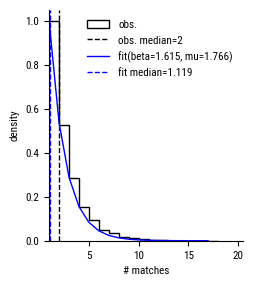

ppm=5.6 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 6.76786182e-01 4.50798220e-01 3.17194452e-01
 2.01910495e-01 1.66317718e-01 1.11881706e-01 7.82517666e-02
 5.35200209e-02 3.44150746e-02 2.28997645e-02 1.72729652e-02
 1.15153101e-02 9.15990578e-03 6.41193405e-03 6.15022245e-03
 4.05652970e-03 2.22454855e-03 2.74797174e-03 2.35540434e-03
 9.15990578e-04 1.30855797e-04 0.00000000e+00 2.61711594e-04
 1.30855797e-04]


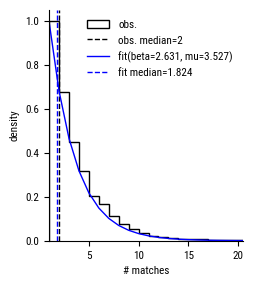

ppm=5.6 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
[1.00000000e+00 7.30433094e-01 5.71373082e-01 4.84754321e-01
 3.74053214e-01 3.05302000e-01 2.34026024e-01 2.07613129e-01
 1.57700524e-01 1.19246456e-01 9.88541464e-02 9.32219849e-02
 6.48669645e-02 5.22431540e-02 4.29209555e-02 3.39871820e-02
 2.38881336e-02 2.46649835e-02 1.70906972e-02 1.47601476e-02
 1.35948728e-02 9.90483589e-03 9.32219849e-03 8.73956108e-03
 5.43794912e-03 3.49582443e-03 4.07846184e-03 1.35948728e-03
 1.35948728e-03 2.13633715e-03 1.35948728e-03 9.71062342e-04
 1.16527481e-03 3.88424937e-04 5.82637405e-04 5.82637405e-04
 1.94212468e-04]


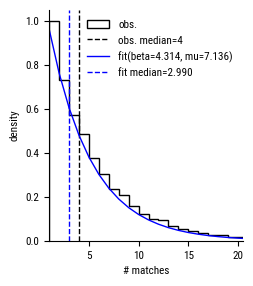

ppm=5.6 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
[1.00000000e+00 8.08600848e-01 6.75348274e-01 5.91762568e-01
 5.23319200e-01 4.62447002e-01 4.20048455e-01 3.80375530e-01
 2.99515445e-01 2.77104785e-01 2.29557844e-01 2.03815869e-01
 1.79285282e-01 1.62931557e-01 1.45063598e-01 1.19624470e-01
 1.22652938e-01 9.41853422e-02 7.90430042e-02 6.63234403e-02
 6.57177468e-02 6.11750454e-02 4.39127801e-02 3.51302241e-02
 4.42156269e-02 3.36159903e-02 3.99757723e-02 2.54391278e-02
 1.75651121e-02 1.75651121e-02 1.36281042e-02 1.48394912e-02
 1.66565718e-02 1.39309509e-02 1.18110236e-02 7.26832223e-03
 6.35978195e-03 5.14839491e-03 4.84554815e-03 3.33131435e-03
 7.26832223e-03 5.45124167e-03 3.63416111e-03 1.51423380e-03
 3.02846760e-03 3.02846760e-04 9.08540279e-04 6.05693519e-04
 1.81708056e-03 2.11992732e-03 1.81708056e-03 9.08540279e-04
 0.00000000e+00 6.0569

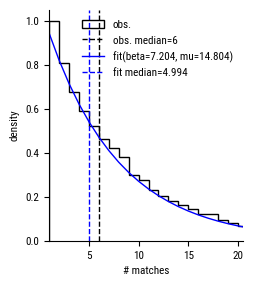

ppm=10.0 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 6.20726725e-01 3.73468071e-01 2.10814879e-01
 1.38249839e-01 8.10578370e-02 5.40743926e-02 2.46183616e-02
 1.97806923e-02 1.22554289e-02 5.48269189e-03 4.19264674e-03
 2.25757902e-03 5.37518813e-04 1.82756396e-03 1.07503763e-03
 2.15007525e-04]


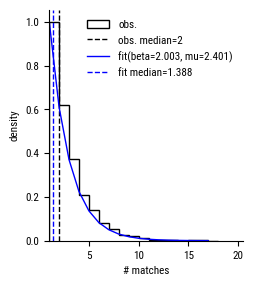

ppm=10.0 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 7.84198113e-01 5.91475741e-01 4.29582210e-01
 3.17890836e-01 2.30289757e-01 1.71664420e-01 1.42183288e-01
 8.81064690e-02 6.72169811e-02 4.26212938e-02 3.57142857e-02
 2.08894879e-02 1.97102426e-02 1.34770889e-02 1.12870620e-02
 9.09703504e-03 4.38005391e-03 6.57008086e-03 4.04312668e-03
 3.87466307e-03 5.05390836e-04 8.42318059e-04 6.73854447e-04
 6.73854447e-04]


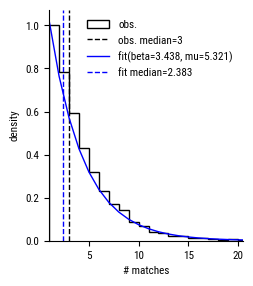

ppm=10.0 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[1.00000000e+00 8.54679803e-01 7.31527094e-01 6.15763547e-01
 5.33114395e-01 4.82484948e-01 3.75752600e-01 3.37438424e-01
 2.77230432e-01 2.15654078e-01 1.89928845e-01 1.50246305e-01
 1.33004926e-01 1.13574165e-01 8.34701697e-02 7.11548987e-02
 5.61029009e-02 4.51559934e-02 4.02298851e-02 2.95566502e-02
 3.06513410e-02 1.75150520e-02 1.88834154e-02 1.69677066e-02
 1.45046524e-02 8.21018062e-03 9.57854406e-03 8.75752600e-03
 5.74712644e-03 2.73672687e-03 5.19978106e-03 6.02079912e-03
 1.91570881e-03 1.64203612e-03 4.37876300e-03 1.91570881e-03
 2.73672687e-04 1.91570881e-03 0.00000000e+00 2.73672687e-04]


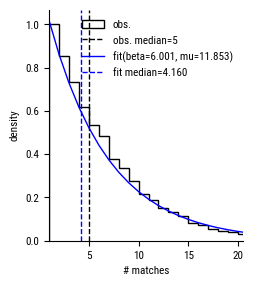

ppm=10.0 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59]
[1.00000000e+00 8.46324181e-01 8.04251550e-01 6.93534101e-01
 6.53232950e-01 6.30646590e-01 6.00088574e-01 5.48715678e-01
 4.95571302e-01 4.13640390e-01 4.04340124e-01 3.61381754e-01
 3.23294951e-01 2.83436670e-01 2.42249779e-01 2.33392383e-01
 2.17449070e-01 1.88662533e-01 1.58104517e-01 1.60761736e-01
 1.60761736e-01 1.31089460e-01 1.19574845e-01 9.16740478e-02
 8.41452613e-02 8.01594331e-02 7.21877768e-02 6.28875111e-02
 5.89016829e-02 5.13728964e-02 2.96722764e-02 2.39149690e-02
 2.87865368e-02 3.58724535e-02 2.83436670e-02 1.72719221e-02
 2.25863596e-02 2.08148804e-02 1.01860053e-02 1.06288751e-02
 1.15146147e-02 1.28432241e-02 2.03720106e-02 1.01860053e-02
 7.97165633e-03 3.10008857e-03 5.75730735e-03 5.31443756e-03
 8.41452613e-03 3.98582817e-03 4.87156776e-03 3.54295837e-03
 3.985828

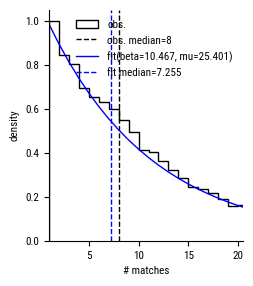

ppm=17.8 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 7.35504886e-01 4.98241042e-01 3.18306189e-01
 2.13029316e-01 1.34983713e-01 8.24755700e-02 5.08143322e-02
 3.60912052e-02 2.05863192e-02 1.27687296e-02 8.46905537e-03
 3.90879479e-03 6.51465798e-04 1.30293160e-03 1.43322476e-03
 3.90879479e-04]


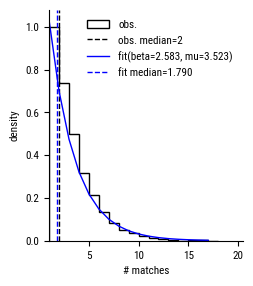

ppm=17.8 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
[1.00000000e+00 8.35741606e-01 7.19082023e-01 5.84572886e-01
 4.55588610e-01 3.47216320e-01 2.88355291e-01 2.24394390e-01
 1.62345941e-01 1.18784530e-01 9.15852104e-02 6.77858054e-02
 4.56863578e-02 4.41988950e-02 2.93242669e-02 2.46493838e-02
 1.65745856e-02 7.86230344e-03 7.43731407e-03 3.82490438e-03
 5.73735657e-03 8.49978751e-04 1.69995750e-03 1.27496813e-03
 1.06247344e-03 8.49978751e-04 0.00000000e+00 2.12494688e-04]


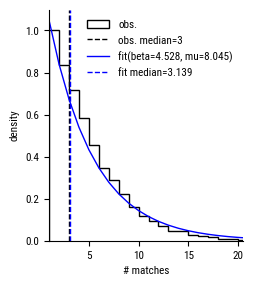

ppm=17.8 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
[1.00000000e+00 8.76228613e-01 8.12158719e-01 7.44812523e-01
 6.86203131e-01 5.95558791e-01 5.73716782e-01 5.01274117e-01
 4.41936658e-01 3.64761558e-01 3.32726611e-01 2.71933018e-01
 2.57371678e-01 2.12231525e-01 1.84929013e-01 1.39788861e-01
 1.16854751e-01 9.13724063e-02 8.95522388e-02 6.91663633e-02
 6.47979614e-02 4.62322534e-02 4.87804878e-02 3.20349472e-02
 3.74954496e-02 3.23989807e-02 1.63815071e-02 1.82016746e-02
 1.49253731e-02 3.64033491e-03 5.82453586e-03 6.91663633e-03
 2.54823444e-03 7.28066982e-03 5.46050237e-03 1.82016746e-03
 2.54823444e-03 1.82016746e-03 3.64033491e-04 1.45613396e-03
 3.64033491e-04 0.00000000e+00 3.64033491e-04]


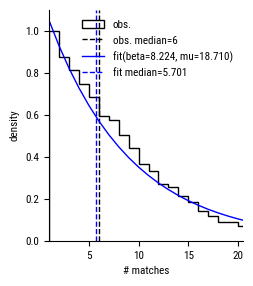

ppm=17.8 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
[1.00000000e+00 8.59841560e-01 8.10481414e-01 7.75137112e-01
 7.45886654e-01 7.17245582e-01 7.20901889e-01 6.73369896e-01
 6.24619135e-01 6.14868982e-01 5.56368068e-01 5.41133455e-01
 5.27117611e-01 4.85679464e-01 4.34491164e-01 4.14381475e-01
 3.63193175e-01 3.61365021e-01 3.10786106e-01 3.12004875e-01
 2.82754418e-01 2.57160268e-01 2.03534430e-01 1.93784278e-01
 1.79159049e-01 1.72455820e-01 1.65143205e-01 1.31017672e-01
 1.34673979e-01 1.11517367e-01 1.14564290e-01 8.34856795e-02
 8.65326021e-02 8.10481414e-02 5.85009141e-02 6.21572212e-02
 5.17976843e-02 4.87507617e-02 3.59536868e-02 3.47349177e-02
 4.08287629e-02 3.47349177e-02 3.10786106e-02 3.10786106e-02
 1.82815356e-02 1.09689214e-02 1.15783059e-02 9.14076782e-03
 1.21876904e-02 9.75015235e-03 1.4015844

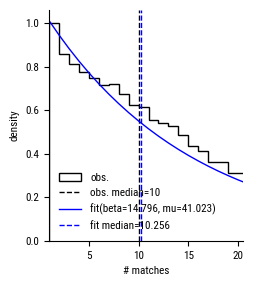

ppm=31.6 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1.00000000e+00 8.23507393e-01 6.40464159e-01 5.23675838e-01
 4.14935430e-01 3.10686880e-01 2.36571215e-01 1.63765675e-01
 1.24274752e-01 8.60939547e-02 5.12820513e-02 4.15496912e-02
 2.75126334e-02 1.60958263e-02 8.98371701e-03 6.73778776e-03
 5.42766236e-03 2.62025080e-03 1.68444694e-03 0.00000000e+00
 3.74321542e-04 0.00000000e+00 5.61482313e-04]


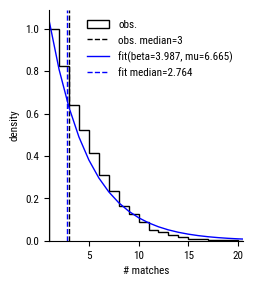

ppm=31.6 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[1.00000000e+00 9.50099800e-01 8.36992681e-01 7.27877578e-01
 6.25415835e-01 5.48902196e-01 5.21956088e-01 4.52761144e-01
 3.82235529e-01 3.46640053e-01 2.80439122e-01 2.36526946e-01
 1.87292083e-01 1.79973387e-01 1.49367931e-01 1.17764471e-01
 1.02129075e-01 8.25016633e-02 5.98802395e-02 4.69061876e-02
 3.82568197e-02 2.92747838e-02 1.92947438e-02 1.56353959e-02
 1.19760479e-02 9.64737192e-03 4.65735196e-03 2.32867598e-03
 3.32667997e-04 1.33067199e-03 9.98003992e-04 0.00000000e+00
 6.65335995e-04 1.99600798e-03 6.65335995e-04 1.66333999e-03
 3.32667997e-04 0.00000000e+00 3.32667997e-04]


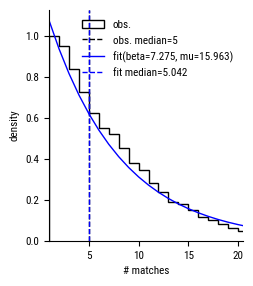

ppm=31.6 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
[9.69893743e-01 1.00000000e+00 8.86068477e-01 8.50059032e-01
 7.65053129e-01 7.84533648e-01 7.13105077e-01 6.75914994e-01
 6.19244392e-01 5.34828808e-01 4.99409681e-01 5.04722550e-01
 5.00000000e-01 4.38606848e-01 3.88429752e-01 3.73081464e-01
 3.80755608e-01 3.27626919e-01 2.99291617e-01 2.72136954e-01
 2.86304604e-01 2.28453365e-01 2.16056671e-01 1.85360094e-01
 1.72963400e-01 1.70602125e-01 1.46399055e-01 1.29279811e-01
 1.18654073e-01 9.09090909e-02 8.55962220e-02 8.85478158e-02
 7.14285714e-02 5.84415584e-02 5.07674144e-02 4.89964581e-02
 4.36835891e-02 3.65997639e-02 3.06965762e-02 1.94805195e-02
 1.82998819e-02 1.53482881e-02 1.18063754e-02 8.85478158e-03
 8.26446281e-03 4.13223140e-03 1.77095632e-03 1.77095632e-03
 1.00354191e-02 2.36127509e-03 0.00000000e+00 2.36127509e-

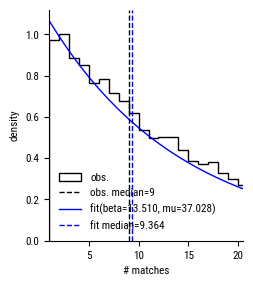

ppm=31.6 tol=1.6
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130]
[1.         0.94871795 0.94564103 0.86666667 0.87487179 0.7774359
 0.76512821 0.74871795 0.70153846 0.79076923 0.72102564 0.66564103
 0.66769231 0.61948718 0.60923077 0.60205128 0.56717949 0.51794872
 0.56717949 0.45025641 0.48923077 0.43282051 0.48205128 0.41641026
 0.41948718 0.39897436 0.43487179 0.44205128 0.35897436 0.39692308
 0.29025641 0.3025641  0.34153846 0.31384615 0.2974359  0.26974359
 0.22461538 0.28512821 0.24615385 0.25333333 0.181538

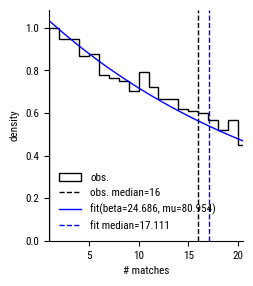

src_ids=(374, 375)
ppm=0.6 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[1.00000000e+00 1.24186047e-01 3.93023256e-02 1.58139535e-02
 7.44186047e-03 2.32558140e-03 6.97674419e-04 1.39534884e-03
 0.00000000e+00 4.65116279e-04 2.32558140e-04 4.65116279e-04]


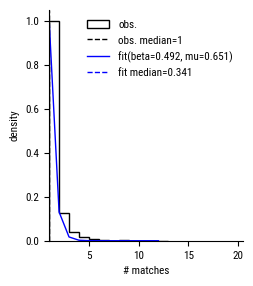

ppm=0.6 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[1.00000000e+00 1.57566692e-01 6.30765395e-02 2.66766392e-02
 1.34629768e-02 9.97257542e-03 1.74520070e-03 2.49314385e-03
 9.97257542e-04 7.47943156e-04 4.98628771e-04 9.97257542e-04]


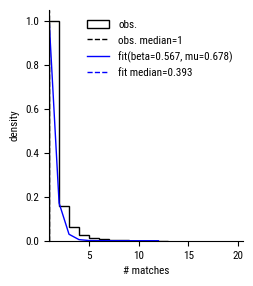

ppm=0.6 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[1.00000000e+00 2.04743730e-01 8.53326063e-02 4.14394766e-02
 2.42639040e-02 1.52671756e-02 8.72410033e-03 7.63358779e-03
 3.27153762e-03 1.90839695e-03 1.90839695e-03 1.09051254e-03
 5.45256270e-04 1.63576881e-03]


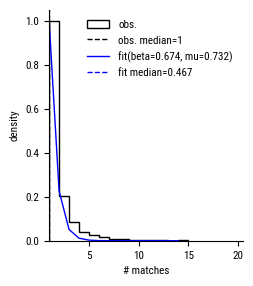

ppm=0.6 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.00000000e+00 2.29091995e-01 1.21565114e-01 5.37634409e-02
 3.85304659e-02 3.22580645e-02 1.28434886e-02 1.22461171e-02
 9.85663082e-03 5.07765830e-03 6.57108722e-03 8.96057348e-04
 1.19474313e-03 8.96057348e-04 3.88291517e-03 2.98685783e-04
 2.98685783e-04 8.96057348e-04 8.96057348e-04 2.98685783e-04]


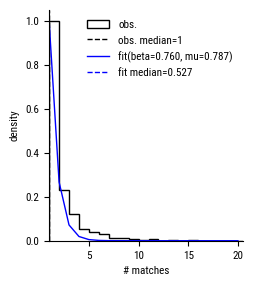

ppm=1.0 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[1.00000000e+00 1.47454371e-01 4.44284342e-02 1.96926033e-02
 8.64553314e-03 2.16138329e-03 9.60614793e-04 9.60614793e-04
 7.20461095e-04 2.40153698e-04 0.00000000e+00 2.40153698e-04]


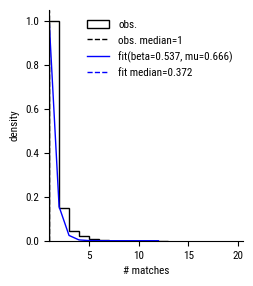

ppm=1.0 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[1.00000000e+00 1.86418797e-01 6.84224116e-02 3.12419313e-02
 1.31680868e-02 5.93854893e-03 4.13116447e-03 3.61476891e-03
 1.03279112e-03 2.06558224e-03 5.16395559e-04 7.74593338e-04
 2.58197779e-04]


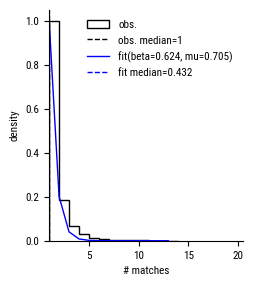

ppm=1.0 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[1.00000000e+00 2.15625875e-01 9.80117614e-02 4.00448054e-02
 2.82833940e-02 1.62419490e-02 9.24110893e-03 7.56090731e-03
 3.92047046e-03 2.52030244e-03 5.60067208e-04 1.96023523e-03
 2.80033604e-03 1.12013442e-03 8.40100812e-04 2.80033604e-04]


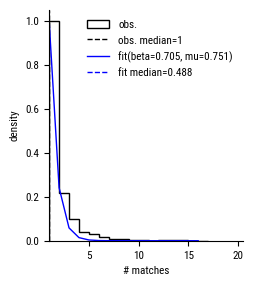

ppm=1.0 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1.00000000e+00 2.33878433e-01 1.40388769e-01 5.83153348e-02
 4.35050910e-02 3.02375810e-02 1.66615242e-02 1.32675100e-02
 9.25640234e-03 7.71366862e-03 5.55384141e-03 2.77692070e-03
 2.46837396e-03 3.08546745e-03 3.70256094e-03 9.25640234e-04
 0.00000000e+00 3.08546745e-04 0.00000000e+00 6.17093490e-04
 1.23418698e-03 3.08546745e-04 3.08546745e-04]


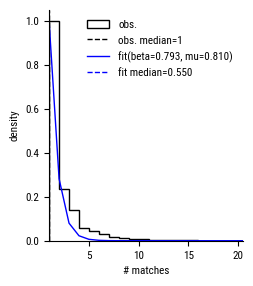

ppm=1.8 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[1.00000000e+00 1.80071721e-01 5.78893443e-02 2.56147541e-02
 1.51127049e-02 9.73360656e-03 1.28073770e-03 1.79303279e-03
 5.12295082e-04 2.56147541e-04 2.56147541e-04 2.56147541e-04]


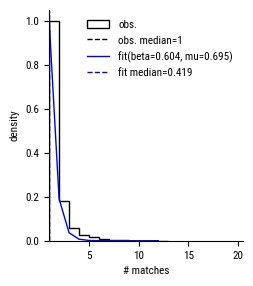

ppm=1.8 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[1.00000000e+00 2.01936376e-01 8.65836791e-02 4.86860304e-02
 2.10235131e-02 1.82572614e-02 5.80912863e-03 3.59612725e-03
 3.04287690e-03 2.48962656e-03 3.04287690e-03 1.10650069e-03
 5.53250346e-04]


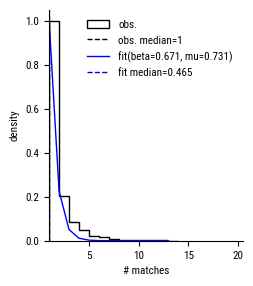

ppm=1.8 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[1.00000000e+00 2.49308331e-01 1.04826314e-01 6.51706117e-02
 4.85705503e-02 3.16630802e-02 1.35259760e-02 1.13741162e-02
 7.68521365e-03 4.30371964e-03 2.15185982e-03 3.07408546e-03
 3.38149401e-03 2.15185982e-03 9.22225638e-04 1.84445128e-03
 9.22225638e-04 6.14817092e-04]


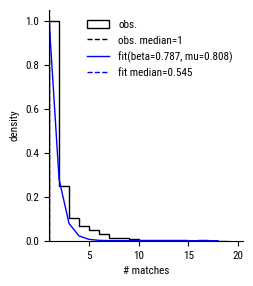

ppm=1.8 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
[1.00000000e+00 2.83207158e-01 1.34893324e-01 8.05230557e-02
 5.91878871e-02 4.40467997e-02 4.54232622e-02 1.96145905e-02
 1.44528562e-02 1.51410874e-02 9.97935306e-03 5.84996559e-03
 4.12938747e-03 4.47350310e-03 4.81761872e-03 1.72057811e-03
 1.72057811e-03 1.03234687e-03 1.03234687e-03 6.88231246e-04
 1.72057811e-03 1.37646249e-03 0.00000000e+00 6.88231246e-04
 3.44115623e-04 0.00000000e+00 6.88231246e-04]


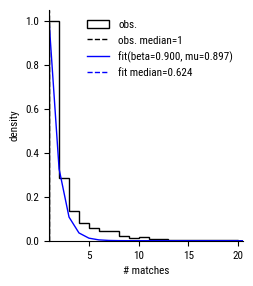

ppm=3.2 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[1.00000000e+00 1.72627919e-01 5.56383507e-02 2.85643318e-02
 1.24192747e-02 1.29160457e-02 2.48385494e-03 2.23546945e-03
 7.45156483e-04 7.45156483e-04 4.96770989e-04 0.00000000e+00
 4.96770989e-04 2.48385494e-04]


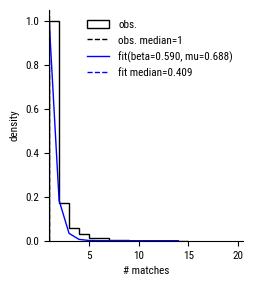

ppm=3.2 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.00000000e+00 2.02753780e-01 8.47732181e-02 4.88660907e-02
 2.48380130e-02 1.34989201e-02 8.09935205e-03 6.47948164e-03
 1.88984881e-03 2.96976242e-03 2.15982721e-03 2.69978402e-03
 1.88984881e-03 2.69978402e-04 5.39956803e-04]


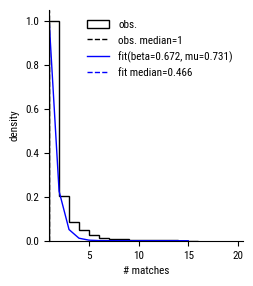

ppm=3.2 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1.00000000e+00 2.42168675e-01 1.08734940e-01 7.28915663e-02
 4.90963855e-02 2.74096386e-02 2.40963855e-02 1.05421687e-02
 5.72289157e-03 5.42168675e-03 2.10843373e-03 6.02409639e-04
 2.40963855e-03 2.71084337e-03 1.80722892e-03 9.03614458e-04
 2.10843373e-03 6.02409639e-04 6.02409639e-04 2.40963855e-03
 1.20481928e-03 0.00000000e+00 3.01204819e-04]


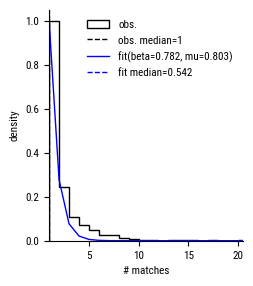

ppm=3.2 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[1.00000000e+00 2.92413793e-01 1.40000000e-01 8.93103448e-02
 6.93103448e-02 5.37931034e-02 4.17241379e-02 2.55172414e-02
 2.17241379e-02 1.44827586e-02 1.06896552e-02 6.20689655e-03
 3.79310345e-03 3.10344828e-03 1.72413793e-03 1.37931034e-03
 6.89655172e-04 3.44827586e-04 3.44827586e-04 3.44827586e-04
 1.03448276e-03 2.75862069e-03 1.37931034e-03 6.89655172e-04
 6.89655172e-04 1.72413793e-03 3.44827586e-04 0.00000000e+00
 1.72413793e-03 0.00000000e+00 1.37931034e-03 1.03448276e-03
 6.89655172e-04]


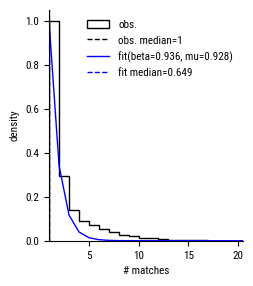

ppm=5.6 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.00000000e+00 2.09850107e-01 7.84261242e-02 3.72055675e-02
 1.73982869e-02 1.41862955e-02 4.01498929e-03 4.81798715e-03
 1.07066381e-03 1.07066381e-03 1.87366167e-03 0.00000000e+00
 5.35331906e-04 2.67665953e-04 5.35331906e-04]


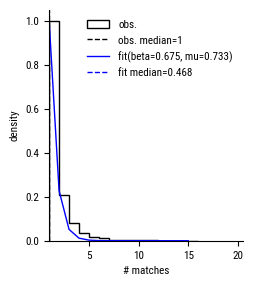

ppm=5.6 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[1.00000000e+00 2.48300325e-01 1.12917529e-01 5.88235294e-02
 2.68992019e-02 2.18740763e-02 1.33018031e-02 1.09370381e-02
 3.54714750e-03 3.84274313e-03 3.54714750e-03 5.91191250e-03
 2.95595625e-03 5.91191250e-04 5.91191250e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.95595625e-04]


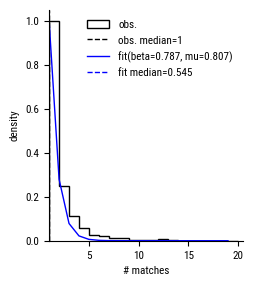

ppm=5.6 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
[1.00000000e+00 3.04845222e-01 1.47375505e-01 7.94078062e-02
 5.75370121e-02 3.12920592e-02 2.42261104e-02 2.08613728e-02
 1.00942127e-02 1.11036339e-02 4.71063257e-03 6.72947510e-03
 4.37415882e-03 3.70121131e-03 3.70121131e-03 2.35531629e-03
 5.04710633e-03 1.68236878e-03 1.34589502e-03 1.34589502e-03
 6.72947510e-04 0.00000000e+00 6.72947510e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.72947510e-04]


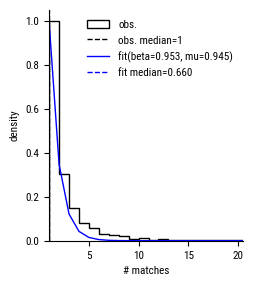

ppm=5.6 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[1.00000000e+00 3.81488934e-01 1.87122736e-01 1.15895372e-01
 1.01408451e-01 5.75452716e-02 4.46680080e-02 2.89738431e-02
 3.38028169e-02 2.17303823e-02 1.69014085e-02 1.77062374e-02
 6.43863179e-03 3.21931590e-03 3.21931590e-03 7.24346076e-03
 4.42655936e-03 2.81690141e-03 3.21931590e-03 1.20724346e-03
 1.60965795e-03 7.24346076e-03 3.62173038e-03 2.41448692e-03
 1.60965795e-03 0.00000000e+00 8.04828974e-04 4.02414487e-04
 8.04828974e-04 0.00000000e+00 1.60965795e-03 4.02414487e-04
 1.20724346e-03 0.00000000e+00 0.00000000e+00 4.02414487e-04
 0.00000000e+00 4.02414487e-04]


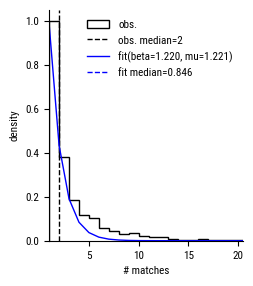

ppm=10.0 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.00000000e+00 2.39237057e-01 8.28337875e-02 4.49591281e-02
 2.07084469e-02 1.47138965e-02 6.53950954e-03 4.08719346e-03
 1.08991826e-03 0.00000000e+00 1.63487738e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.72479564e-04]


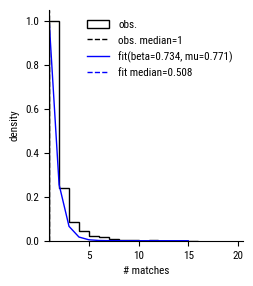

ppm=10.0 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.         0.2999693  0.11789991 0.0614062  0.03745778 0.02916795
 0.01443046 0.01258827 0.00767578 0.00337734 0.0039914  0.00429843
 0.00153516 0.         0.00184219]


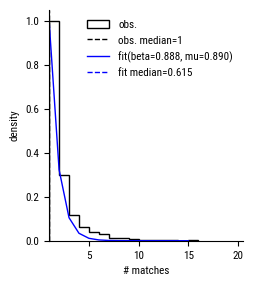

ppm=10.0 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[1.00000000e+00 3.91016200e-01 1.67893962e-01 1.06774669e-01
 6.66421208e-02 4.16053019e-02 4.05007364e-02 2.13549337e-02
 1.65684831e-02 2.20913108e-02 6.99558174e-03 8.46833579e-03
 4.05007364e-03 4.05007364e-03 4.41826215e-03 1.84094256e-03
 3.31369661e-03 3.68188513e-04 1.10456554e-03 3.68188513e-03
 7.36377025e-04]


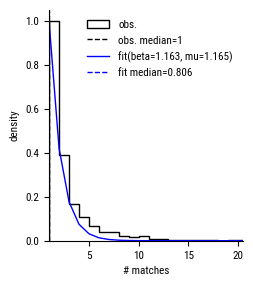

ppm=10.0 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[1.00000000e+00 4.86672794e-01 2.27941176e-01 1.62224265e-01
 1.21783088e-01 7.95036765e-02 6.89338235e-02 4.18198529e-02
 4.73345588e-02 2.20588235e-02 2.25183824e-02 2.34375000e-02
 1.14889706e-02 1.47058824e-02 1.60845588e-02 7.81250000e-03
 1.83823529e-03 3.67647059e-03 3.21691176e-03 2.29779412e-03
 2.29779412e-03 6.43382353e-03 4.13602941e-03 1.83823529e-03
 4.59558824e-04 9.19117647e-04 2.75735294e-03 0.00000000e+00
 4.59558824e-04 1.83823529e-03 0.00000000e+00 4.59558824e-04
 1.37867647e-03]


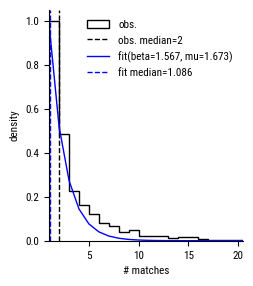

ppm=17.8 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.00000000e+00 2.52176436e-01 1.00406268e-01 4.58502612e-02
 2.58270459e-02 1.71213001e-02 7.83517121e-03 2.03134068e-03
 8.70574579e-04 0.00000000e+00 1.16076611e-03 0.00000000e+00
 2.90191526e-04 2.90191526e-04 2.90191526e-04]


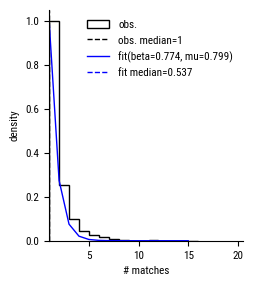

ppm=17.8 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[1.00000000e+00 3.25301205e-01 1.48259705e-01 7.59705489e-02
 4.45113788e-02 3.48058902e-02 1.87416332e-02 1.27175368e-02
 5.68942436e-03 2.34270415e-03 3.34672021e-03 2.67737617e-03
 1.67336011e-03 3.34672021e-04 3.34672021e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.34672021e-04]


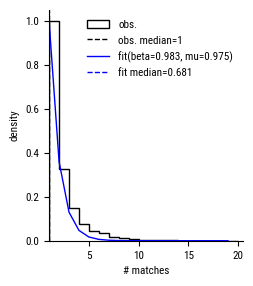

ppm=17.8 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
[1.00000000e+00 4.15441176e-01 2.26715686e-01 1.24591503e-01
 8.37418301e-02 5.84150327e-02 3.51307190e-02 2.32843137e-02
 1.79738562e-02 2.20588235e-02 1.18464052e-02 8.16993464e-03
 6.12745098e-03 4.49346405e-03 2.45098039e-03 8.16993464e-04
 1.22549020e-03 8.16993464e-04 4.08496732e-04 8.16993464e-04
 8.16993464e-04 0.00000000e+00 8.16993464e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.16993464e-04]


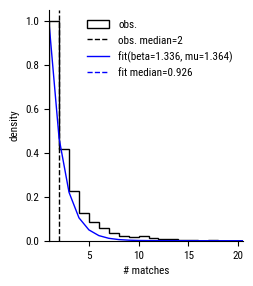

ppm=17.8 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[1.00000000e+00 5.39168017e-01 3.34954079e-01 2.00972447e-01
 1.59913560e-01 9.77849811e-02 8.53592653e-02 4.59211237e-02
 4.32198811e-02 5.51053485e-02 2.53916802e-02 2.21501891e-02
 2.10696921e-02 1.18854673e-02 2.32306861e-02 9.18422474e-03
 8.10372771e-03 3.24149109e-03 3.24149109e-03 0.00000000e+00
 2.16099406e-03 4.32198811e-03 3.24149109e-03 2.16099406e-03
 5.40248514e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.40248514e-04 0.00000000e+00 0.00000000e+00 1.08049703e-03
 1.62074554e-03 5.40248514e-04 0.00000000e+00 5.40248514e-04
 0.00000000e+00 5.40248514e-04]


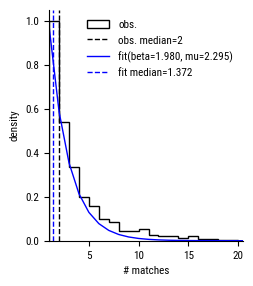

ppm=31.6 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.00000000e+00 3.16773996e-01 1.20515179e-01 6.89972401e-02
 3.21987121e-02 1.74793008e-02 7.35970561e-03 1.22661760e-03
 3.06654400e-03 6.13308801e-04 9.19963201e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.83992640e-03]


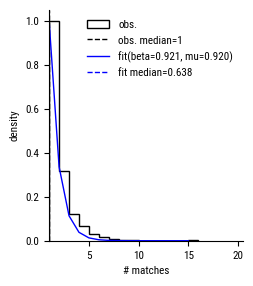

ppm=31.6 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 4.02443539e-01 1.95853388e-01 1.08848575e-01
 7.58978156e-02 5.29433543e-02 2.14735283e-02 1.40688634e-02
 6.66419845e-03 4.07256572e-03 4.07256572e-03 3.33209922e-03
 3.33209922e-03 0.00000000e+00 2.59163273e-03 3.70233247e-04
 7.40466494e-04]


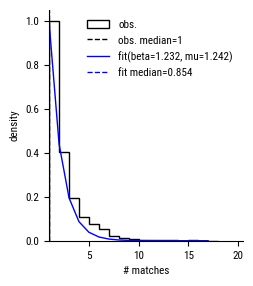

ppm=31.6 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 5.10416667e-01 3.03030303e-01 1.69507576e-01
 1.11742424e-01 9.18560606e-02 8.04924242e-02 4.45075758e-02
 2.03598485e-02 2.32007576e-02 1.79924242e-02 1.37310606e-02
 9.46969697e-03 5.68181818e-03 8.52272727e-03 5.20833333e-03
 3.31439394e-03 1.89393939e-03 9.46969697e-04 9.46969697e-04
 4.73484848e-04 1.42045455e-03 0.00000000e+00 4.73484848e-04
 4.73484848e-04]


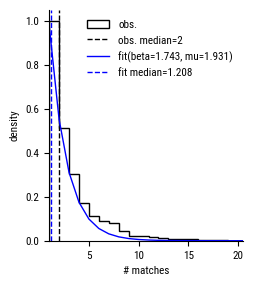

ppm=31.6 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
[1.00000000e+00 6.34615385e-01 4.62864721e-01 2.88461538e-01
 1.98275862e-01 1.46551724e-01 1.54509284e-01 9.21750663e-02
 7.36074271e-02 5.96816976e-02 5.10610080e-02 5.23872679e-02
 2.12201592e-02 4.04509284e-02 2.45358090e-02 2.18832891e-02
 1.45888594e-02 1.45888594e-02 7.29442971e-03 5.96816976e-03
 3.31564987e-03 4.64190981e-03 8.62068966e-03 5.30503979e-03
 1.32625995e-03 2.65251989e-03 0.00000000e+00 6.63129973e-04
 1.32625995e-03 1.32625995e-03 6.63129973e-04 0.00000000e+00
 0.00000000e+00 6.63129973e-04 1.98938992e-03]


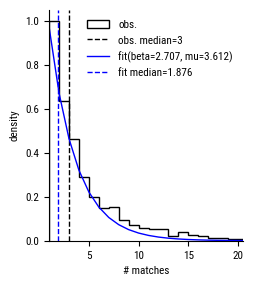

src_ids=(366, 367)
ppm=0.6 tol=0.2
[1 2 3]
[1.         0.05800654 0.00653595]


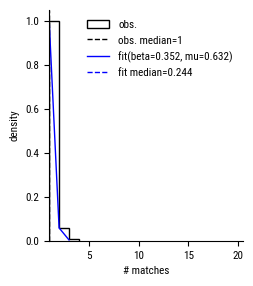

ppm=0.6 tol=0.4
[1 2 3 4 5]
[1.         0.10880829 0.01122625 0.00345423 0.00172712]


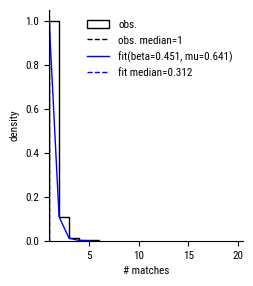

ppm=0.6 tol=0.8
[1 2 3 4 5]
[1.         0.15639374 0.02851886 0.0101196  0.00367985]


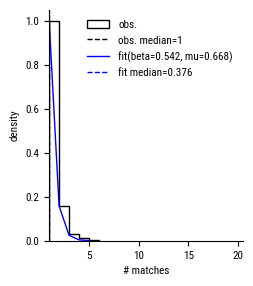

ppm=0.6 tol=1.6
[1 2 3 4 5 6]
[1.         0.18609207 0.05974535 0.02056807 0.00783546 0.00195886]


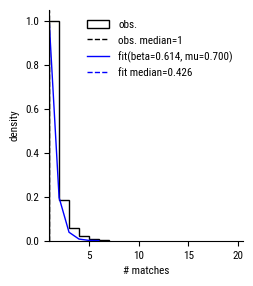

ppm=1.0 tol=0.2
[1 2 3]
[1.         0.0539104  0.00835232]


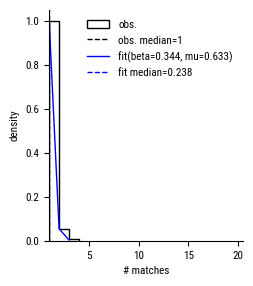

ppm=1.0 tol=0.4
[1 2 3 4]
[1.     0.0896 0.0216 0.008 ]


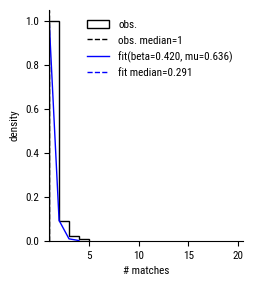

ppm=1.0 tol=0.8
[1 2 3 4 5]
[1.00000000e+00 1.33671743e-01 2.96108291e-02 1.94585448e-02
 8.46023689e-04]


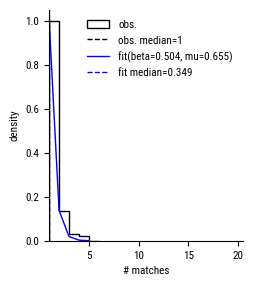

ppm=1.0 tol=1.6
[1 2 3 4 5]
[1.         0.16503993 0.03637977 0.02928128 0.01064774]


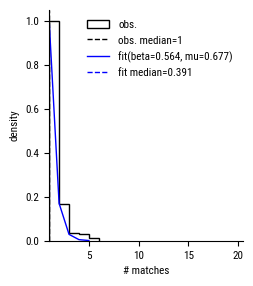

ppm=1.8 tol=0.2
[1 2 3]
[1.         0.07298137 0.00621118]


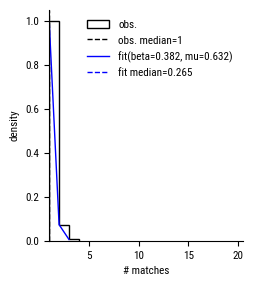

ppm=1.8 tol=0.4
[1 2 3 4]
[1.         0.10638298 0.02045827 0.0106383 ]


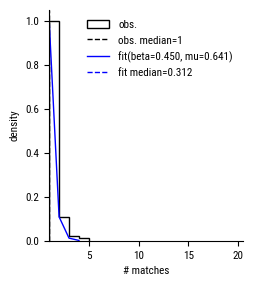

ppm=1.8 tol=0.8
[1 2 3 4 5 6]
[1.         0.14384749 0.0372617  0.01819757 0.0034662  0.0017331 ]


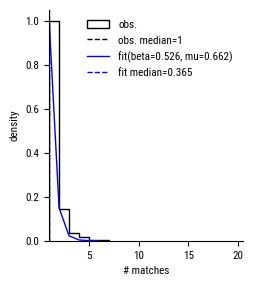

ppm=1.8 tol=1.6
[1 2 3 4 5 6]
[1.         0.19216418 0.04850746 0.04291045 0.01119403 0.00186567]


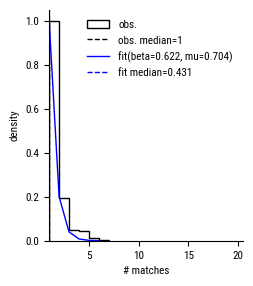

ppm=3.2 tol=0.2
[1 2 3]
[1.         0.07010786 0.01386749]


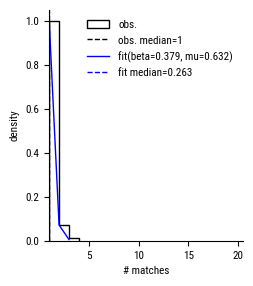

ppm=3.2 tol=0.4
[1 2 3 4 5]
[1.         0.10828548 0.03855619 0.00574241 0.00164069]


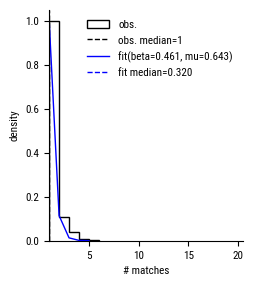

ppm=3.2 tol=0.8
[1 2 3 4 5 6]
[1.         0.16066725 0.05179982 0.01404741 0.00702371 0.00175593]


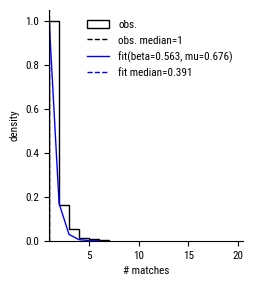

ppm=3.2 tol=1.6
[1 2 3 4 5 6 7]
[1.         0.21414914 0.05927342 0.04780115 0.01720841 0.00478011
 0.00191205]


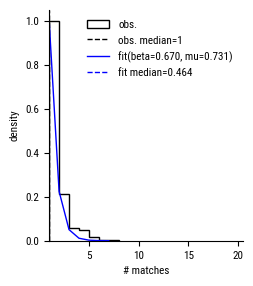

ppm=5.6 tol=0.2
[1 2 3]
[1.         0.07520661 0.00991736]


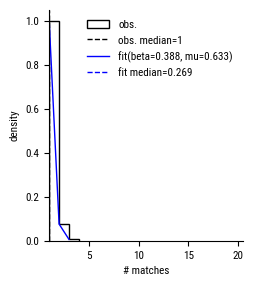

ppm=5.6 tol=0.4
[1 2 3 4]
[1.         0.14145031 0.02059087 0.01342883]


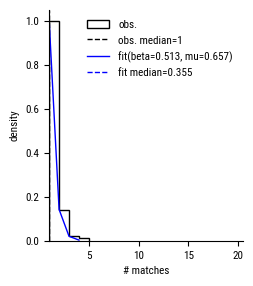

ppm=5.6 tol=0.8
[1 2 3 4 5 6]
[1.         0.16267943 0.05645933 0.03253589 0.00287081 0.00191388]


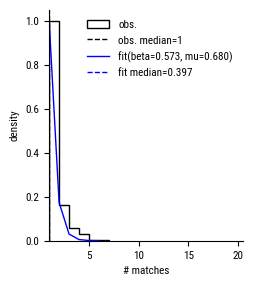

ppm=5.6 tol=1.6
[1 2 3 4 5 6 7]
[1.         0.21458333 0.08125    0.04375    0.01875    0.00729167
 0.00208333]


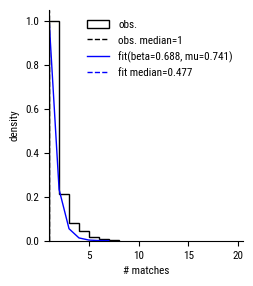

ppm=10.0 tol=0.2
[1 2 3 4]
[1.         0.10361446 0.01204819 0.00160643]


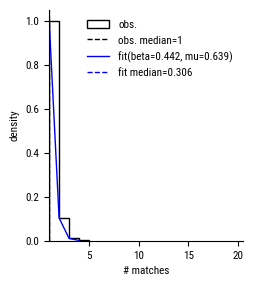

ppm=10.0 tol=0.4
[1 2 3 4]
[1.         0.16623151 0.03220191 0.01218451]


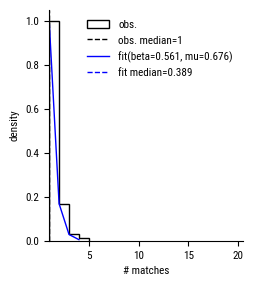

ppm=10.0 tol=0.8
[1 2 3 4 5 6 7]
[1.         0.21415094 0.06603774 0.01792453 0.01037736 0.
 0.00377358]


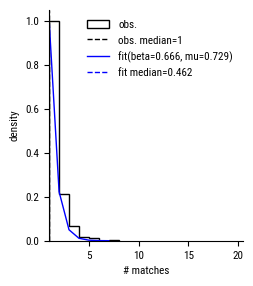

ppm=10.0 tol=1.6
[1 2 3 4 5 6 7]
[1.         0.26200418 0.10334029 0.04384134 0.02713987 0.00835073
 0.00730689]


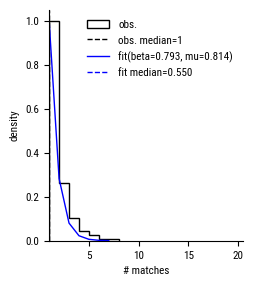

ppm=17.8 tol=0.2
[1 2 3 4]
[1.         0.10995185 0.0176565  0.00160514]


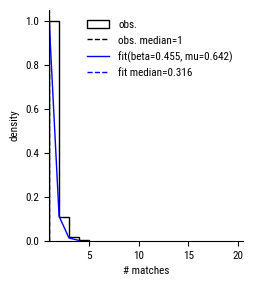

ppm=17.8 tol=0.4
[1 2 3 4 5]
[1.         0.18093557 0.03706973 0.02206531 0.00176523]


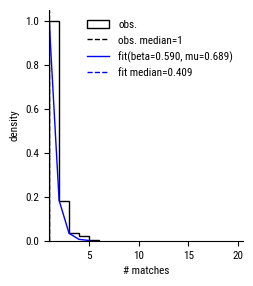

ppm=17.8 tol=0.8
[1 2 3 4 5 6 7]
[1.         0.27524752 0.05940594 0.03069307 0.01188119 0.00990099
 0.00594059]


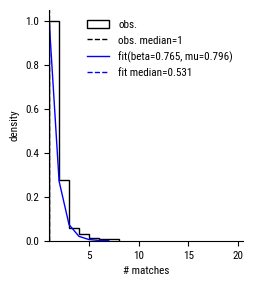

ppm=17.8 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11]
[1.         0.39365452 0.10458284 0.09165687 0.01762632 0.02702703
 0.01410106 0.         0.00235018 0.         0.00235018]


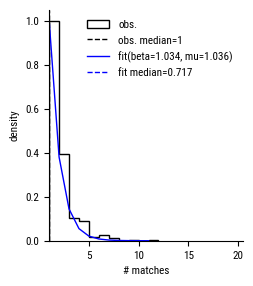

ppm=31.6 tol=0.2
[1 2 3 4]
[1.         0.14297125 0.0071885  0.00878594]


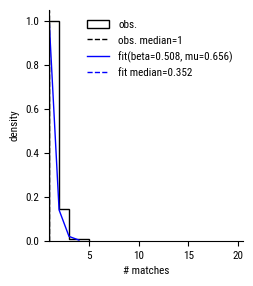

ppm=31.6 tol=0.4
[1 2 3 4 5]
[1.         0.21712268 0.03971756 0.02030009 0.00353045]


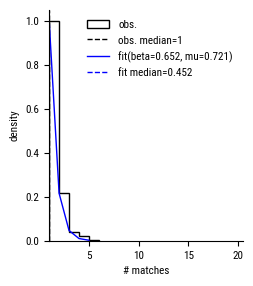

ppm=31.6 tol=0.8
[1 2 3 4 5 6 7]
[1.         0.2998008  0.08665339 0.03286853 0.01992032 0.
 0.0059761 ]


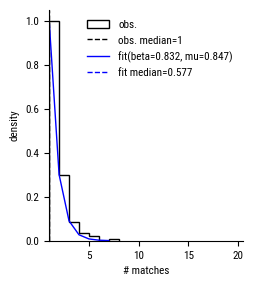

ppm=31.6 tol=1.6
[1 2 3 4 5 6 7 8 9]
[1.         0.41529412 0.14       0.08235294 0.03176471 0.02117647
 0.01058824 0.00352941 0.00235294]


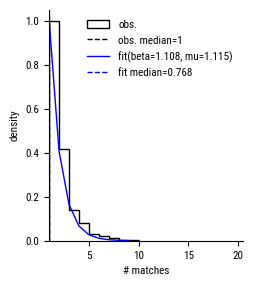

src_ids=(260, 261)
ppm=0.6 tol=0.25
[1 2 3 4 5]
[1.         0.1        0.0195122  0.00365854 0.00121951]


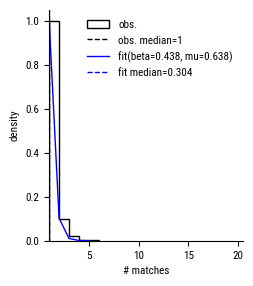

ppm=0.6 tol=0.5
[1 2 3 4 5]
[1.         0.1007371  0.02457002 0.00614251 0.0012285 ]


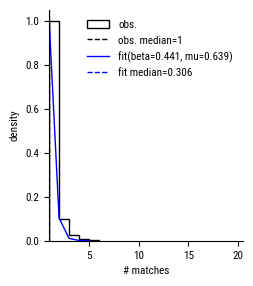

ppm=0.6 tol=1.0
[1 2 3 4 5]
[1.         0.12075472 0.02641509 0.01132075 0.00125786]


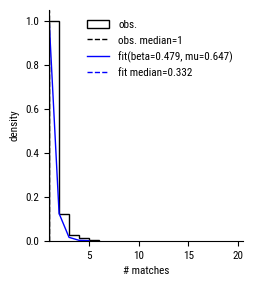

ppm=0.6 tol=2.0
[1 2 3 4 5]
[1.         0.15555556 0.03660131 0.01176471 0.00130719]


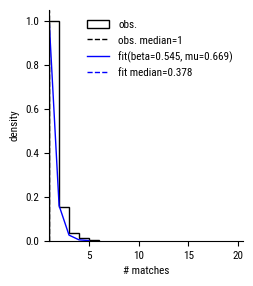

ppm=1.0 tol=0.25
[1 2 3 4 5]
[1.         0.09057528 0.03059976 0.00979192 0.00122399]


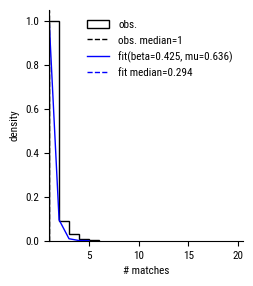

ppm=1.0 tol=0.5
[1 2 3 4 5 6]
[1.         0.09713574 0.03985056 0.0124533  0.00124533 0.00124533]


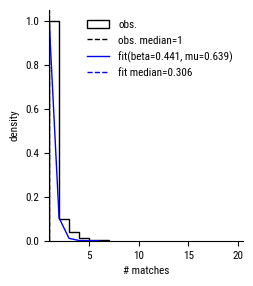

ppm=1.0 tol=1.0
[1 2 3 4 5 6]
[1.         0.1177977  0.04225352 0.02176697 0.00128041 0.00128041]


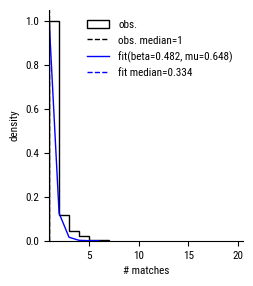

ppm=1.0 tol=2.0
[1 2 3 4 5 6]
[1.         0.13464052 0.04836601 0.02352941 0.00130719 0.00130719]


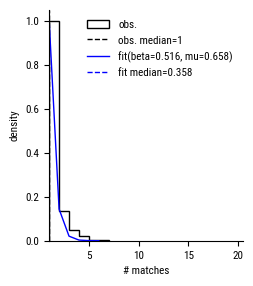

ppm=1.8 tol=0.25
[1 2 3 4]
[1.         0.12820513 0.03030303 0.01048951]


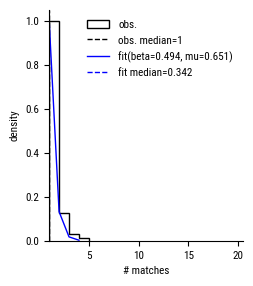

ppm=1.8 tol=0.5
[1 2 3 4 5]
[1.         0.14354067 0.0430622  0.01196172 0.00119617]


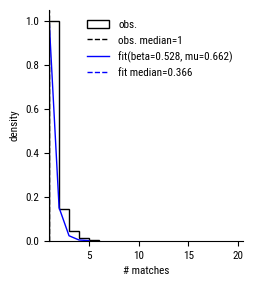

ppm=1.8 tol=1.0
[1 2 3 4 5]
[1.         0.17472119 0.04584882 0.02106568 0.00123916]


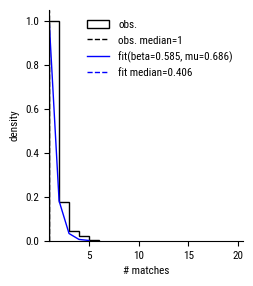

ppm=1.8 tol=2.0
[1 2 3 4 5]
[1.         0.21134021 0.05798969 0.02190722 0.00128866]


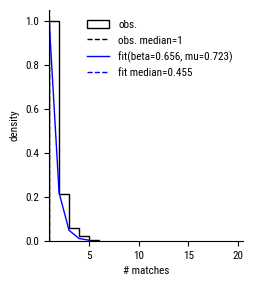

ppm=3.2 tol=0.25
[1 2 3 4 5]
[1.         0.11294118 0.01647059 0.00823529 0.00235294]


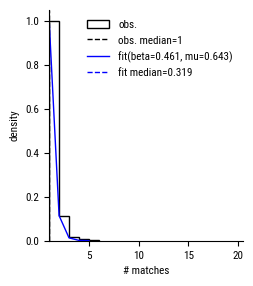

ppm=3.2 tol=0.5
[1 2 3 4 5 6]
[1.         0.13205282 0.0180072  0.00960384 0.00240096 0.00120048]


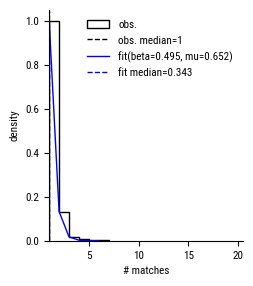

ppm=3.2 tol=1.0
[1 2 3 4 5 6]
[1.         0.16169154 0.02114428 0.01865672 0.00248756 0.00124378]


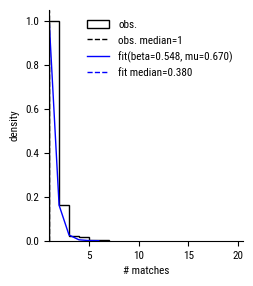

ppm=3.2 tol=2.0
[1 2 3 4 5 6]
[1.         0.1997406  0.03372244 0.01945525 0.00259403 0.00129702]


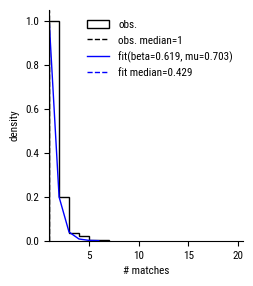

ppm=5.6 tol=0.25
[1 2 3 4 5 6]
[1.         0.14033019 0.03773585 0.00589623 0.         0.00117925]


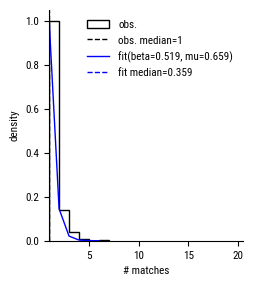

ppm=5.6 tol=0.5
[1 2 3 4 5 6]
[1.         0.16727717 0.05250305 0.00610501 0.         0.001221  ]


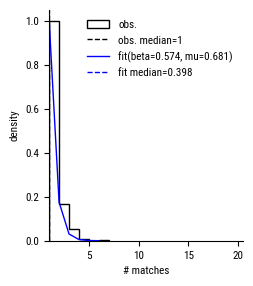

ppm=5.6 tol=1.0
[1 2 3 4 5 6]
[1.         0.2        0.05859873 0.02038217 0.         0.00127389]


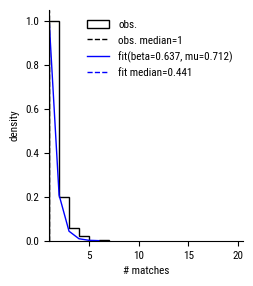

ppm=5.6 tol=2.0
[1 2 3 4 5 6]
[1.         0.28137931 0.07034483 0.0262069  0.00689655 0.00137931]


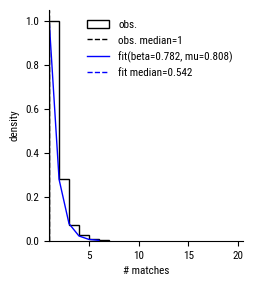

ppm=10.0 tol=0.25
[1 2 3 4 5]
[1.         0.17780749 0.04278075 0.00668449 0.0013369 ]


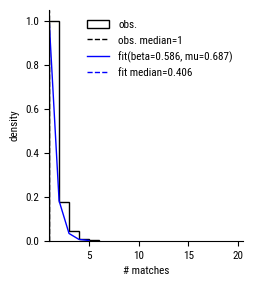

ppm=10.0 tol=0.5
[1 2 3 4 5 6]
[1.         0.21338912 0.05997211 0.0041841  0.0013947  0.0027894 ]


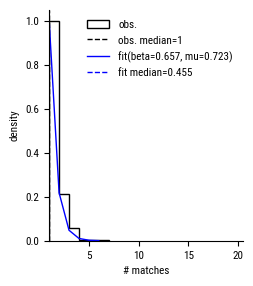

ppm=10.0 tol=1.0
[1 2 3 4 5 6 7 8]
[1.         0.23426061 0.0863836  0.0204978  0.00146413 0.
 0.         0.00292826]


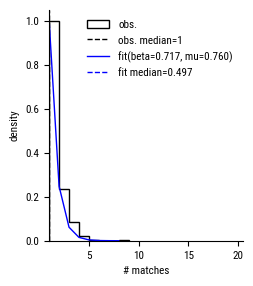

ppm=10.0 tol=2.0
[1 2 3 4 5 6 7 8]
[1.         0.30564263 0.0862069  0.04388715 0.0015674  0.
 0.         0.0031348 ]


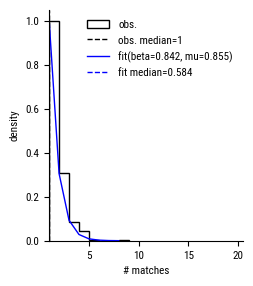

ppm=17.8 tol=0.25
[1 2 3 4]
[1.         0.13364596 0.04337632 0.01172333]


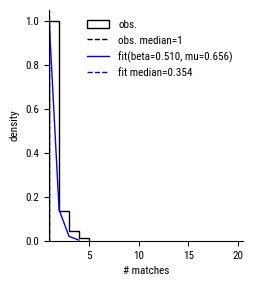

ppm=17.8 tol=0.5
[1 2 3 4 5 6]
[1.         0.16768666 0.05630355 0.00979192 0.         0.00734394]


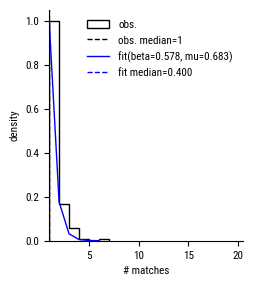

ppm=17.8 tol=1.0
[1 2 3 4 5 6 7 8]
[1.         0.21391076 0.09055118 0.0183727  0.         0.00262467
 0.         0.00524934]


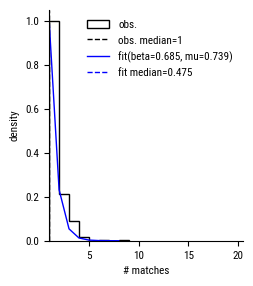

ppm=17.8 tol=2.0
[1 2 3 4 5 6 7 8]
[1.         0.2987013  0.11255411 0.02741703 0.01587302 0.002886
 0.         0.00577201]


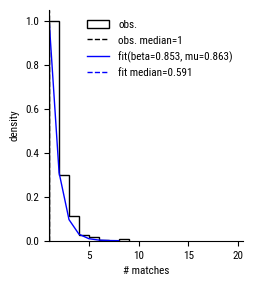

ppm=31.6 tol=0.25
[1 2 3 4 5]
[1.         0.12095808 0.03712575 0.01916168 0.00239521]


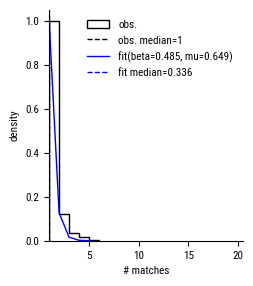

ppm=31.6 tol=0.5
[1 2 3 4 5 6]
[1.         0.16100629 0.04654088 0.02389937 0.00251572 0.00503145]


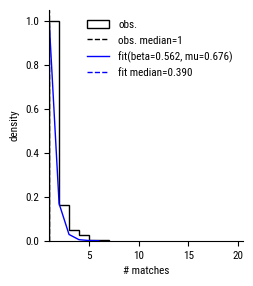

ppm=31.6 tol=1.0
[1 2 3 4 5 6 7 8]
[1.         0.2262069  0.08413793 0.03862069 0.00413793 0.00275862
 0.         0.00275862]


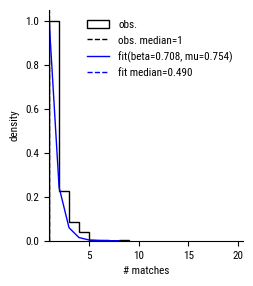

ppm=31.6 tol=2.0
[1 2 3 4 5 6 7 8]
[1.         0.29473684 0.1112782  0.04962406 0.01353383 0.00902256
 0.         0.00300752]


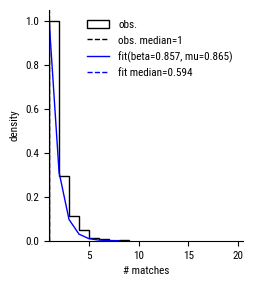

In [23]:
# keep track of fit parameters and summary stats
ppms, tols = {}, {}
betas, mus, obs_meds = {}, {}, {}
for src_ids, rt_tols in RT_TOLERANCES.items():
    print(f"{src_ids=}")
    ppms[src_ids] = []
    tols[src_ids] = []
    betas[src_ids] = []
    mus[src_ids] = []
    obs_meds[src_ids] = []
    for ppm in MZ_PPMS:
        for tol in rt_tols:
            ppms[src_ids].append(ppm)
            tols[src_ids].append(tol)
            print(f"{ppm=} {tol=}")
            fig, ax = plt.subplots(figsize=(2.5, 3))
            bin_max = max(mz_rt_probs[src_ids][(ppm, tol)]) + 2
            c, x = np.histogram(mz_rt_probs[src_ids][(ppm, tol)], np.arange(1, bin_max))
            cn = c / max(c)
            ax.hist(mz_rt_probs[src_ids][(ppm, tol)], bins=np.arange(1, bin_max), color="k", histtype="step", lw=1., 
                    weights=[1 / max(c)] * len(mz_rt_probs[src_ids][(ppm, tol)]), label="obs.") 
            obs_med = np.median(mz_rt_probs[src_ids][(ppm, tol)])
            ax.axvline(obs_med, ls="--", lw=1., label=f"obs. median={obs_med:.0f}", c="k")
            print(x[:-1])
            print(cn)
            (beta, mu), _ = optimize.curve_fit(fexp, x[:-1], cn)
            ax.plot(x[:-1], fexp(x[:-1], beta, mu), 'b-', lw=1., label=f"fit({beta=:.3f}, {mu=:.3f})")
            fit_med = beta * np.log(2.)
            ax.axvline(fit_med, ls="--", lw=1., label=f"fit median={fit_med:.3f}", c="b")
            ax.legend(frameon=False)
            for d in ["top", "right"]:
                ax.spines[d].set_visible(False)
            #ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
            ax.set_xlabel("# matches")
            ax.set_ylabel("density")
            ax.set_xlim([1, 20 + 0.5])
            plt.savefig(f"_figures/mz_rt/{"-".join([str(_) for _ in src_ids])}_{ppm=}_{tol=}_dist_with_fit.png", 
                        dpi=400, bbox_inches="tight")
            plt.show()
            plt.close()
            betas[src_ids].append(beta)
            mus[src_ids].append(mu)
            obs_meds[src_ids].append(obs_med)

fit_meds = {
    src_ids: [_ * np.log(2) for _ in betas[src_ids]]
    for src_ids in [(186,), (374, 375), (366, 367), (260, 261)]
}

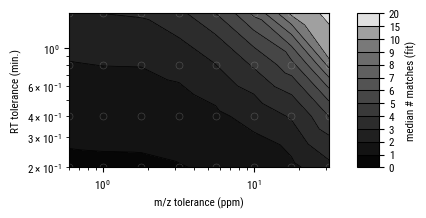

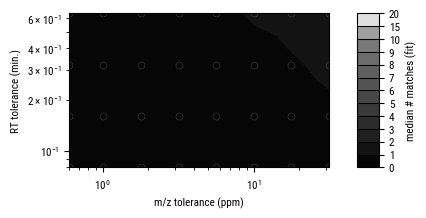

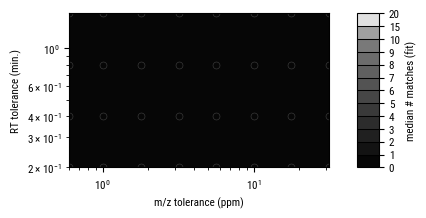

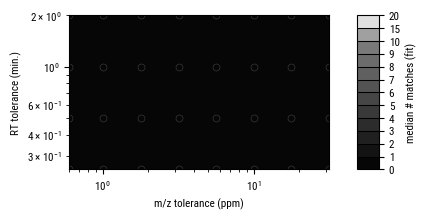

In [28]:
for src_ids, rt_tols in RT_TOLERANCES.items():
    fig, (ax, axcb) = plt.subplots(ncols=2, width_ratios=(12, 1), figsize=(4, 2))
    mz_bins = MZ_PPMS + [56]
    rt_bins = rt_tols + RT_TOLERANCES_EXTRA[src_ids]
    levels = [_ for _ in range(10)] + [10, 15, 20]
    tcf = ax.tricontourf(ppms[src_ids], tols[src_ids], fit_meds[src_ids], levels, cmap="binary_r")
    ax.tricontour(ppms[src_ids], tols[src_ids], fit_meds[src_ids], levels, colors="k", linewidths=0.5)
    ax.plot(ppms[src_ids], tols[src_ids], "wo", ms=5, fillstyle="none", mew=0.5, alpha=0.2)
    ax.set_xlabel("m/z tolerance (ppm)")
    ax.set_ylabel("RT tolerance (min.)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    cb = fig.colorbar(tcf, cax=axcb)
    cb.set_ticks(levels)
    cb.set_ticklabels(levels)
    for l in levels[1:-1]:
        cb.ax.axhline(l, lw=0.75, c="k")
    cb.set_label("median # matches (fit)")
    plt.savefig(f"_figures/mz_rt/{"-".join([str(_) for _ in src_ids])}_2D_tolerance_contour.png", 
                dpi=400, bbox_inches="tight")
    plt.show()
    plt.close()

In [25]:
[(min(fit_meds[k]), max(fit_meds[k])) for k in RT_TOLERANCES.keys()]

[(0.8755604557817127, 17.110906279029976),
 (0.34078725611871674, 1.8762211472239756),
 (0.23822825921888965, 0.7681875882171026),
 (0.2943911481467104, 0.5938341228843339)]

# m/z + MS2

## Initialize and Cache

In [9]:
mz_ms2 = {"mz_ms2_probs": {}, "mzs": {}}

In [50]:
db = IdPPdb("idpp_cleaned.db", read_only=True, enforce_idpp_ver=False)

for i in range(5):
    random.seed(i + 160)
    for ppm in MZ_PPMS:
        print(f"{ppm=}")
        selected = 0
        for i, (id_A, matched_A) in enumerate(mz_results[ppm].items()):
            if random.random() > 0.005:
                # most of the time just skip
                continue
            selected += 1
            #print("---")
            #print(f"{id_A=} {matched_A=}")
            aid_A = cmpd_id_to_adduct_id[id_A]
            #print(f"{aid_A=}")
            # id_A is a compound ID, need to convert to adduct ID(s) then use that(those) to
            # create an MS2Tree on the fly for matches to this compound
            matched_aids = set([aid for cid in matched_A for aid in cmpd_id_to_adduct_id[cid]])
            #print(f"{matched_aids=}")
            try:
                if (ms2t := construct_ms2_tree_for_adduct_ids(db, matched_aids)) is not None:
                    for tol in MS2_TOLERANCES:
                        #print(f"{tol=}")
                        qres = ms2t.query_all(tol)
                        #print(f"{qres=}")
                        q_aids = set()
                        for aid_A in cmpd_id_to_adduct_id[id_A]:
                            if aid_A in qres:
                                q_aids |= qres[aid_A]
                        if len(q_aids) > 0:
                            #print(f"{q_aids=}")
                            common_aids = matched_aids & q_aids
                            common_cids = set([ms2t.adduct_to_cmpd_id[aid] for aid in common_aids])
                            #print(f"{common_aids=}")
                            #print(f"{common_cids=}")
                            n = len(common_cids)
                            m = len(matched_A)
                            #print(f"{n=} {m=}")
                            k = (ppm, tol)
                            if k in mz_ms2["mz_ms2_probs"]:
                                mz_ms2["mz_ms2_probs"][k].append(n)
                            else:
                                mz_ms2["mz_ms2_probs"][k] = [n]
                            if k in mz_ms2["mzs"]:
                                mz_ms2["mzs"][k].append(m)
                            else:
                                mz_ms2["mzs"][k] = [m]
                print(f"\rsampled {selected} of {i + 1}  ({100 * (selected / (i + 1)):.1f} %)", end="    ")
            except KeyboardInterrupt:
                break
            except:
                continue
        print()
        # cache the results after each ppm completes
        with open("_cache/mz_ms2.pkl", "wb") as pf:
            pickle.dump(mz_ms2, pf)

db.close()

ppm=0.6
sampled 786 of 165883  (0.5 %)    
ppm=1.0
sampled 841 of 165903  (0.5 %)    
ppm=1.8
sampled 835 of 165851  (0.5 %)    
ppm=3.2
sampled 884 of 165856  (0.5 %)    
ppm=5.6
sampled 829 of 165465  (0.5 %)    
ppm=10.0
sampled 821 of 165618  (0.5 %)    
ppm=17.8
sampled 847 of 165813  (0.5 %)    
ppm=31.6
sampled 818 of 165682  (0.5 %)    
ppm=0.6
sampled 872 of 165861  (0.5 %)    
ppm=1.0
sampled 899 of 165901  (0.5 %)    
ppm=1.8
sampled 886 of 165871  (0.5 %)    
ppm=3.2
sampled 873 of 165496  (0.5 %)    
ppm=5.6
sampled 898 of 165903  (0.5 %)    
ppm=10.0
sampled 873 of 165545  (0.5 %)    
ppm=17.8
sampled 853 of 165652  (0.5 %)    
ppm=31.6
sampled 856 of 165799  (0.5 %)    
ppm=0.6
sampled 775 of 165606  (0.5 %)    
ppm=1.0
sampled 855 of 165907  (0.5 %)    
ppm=1.8
sampled 779 of 165428  (0.5 %)    
ppm=3.2
sampled 770 of 165914  (0.5 %)    
ppm=5.6
sampled 828 of 165892  (0.5 %)    
ppm=10.0
sampled 823 of 165462  (0.5 %)    
ppm=17.8
sampled 829 of 165819  (0.5 %)    
ppm

In [ ]:
# cache the results
with open("_cache/mz_ms2.pkl", "wb") as pf:
    pickle.dump(mz_ms2, pf)

## Load Cached

In [ ]:
with open("_cache/mz_ms2.pkl", "rb") as pf:
    mz_ms2 = pickle.load(pf)

## Plots

ppm=0.6 tol=0.99


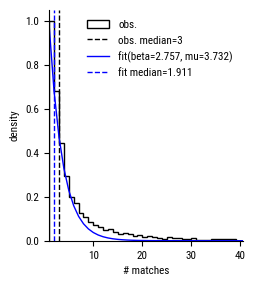

ppm=0.6 tol=0.95


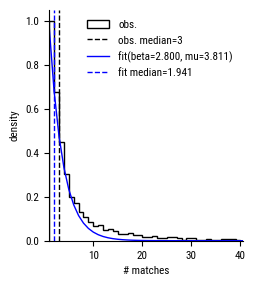

ppm=0.6 tol=0.9


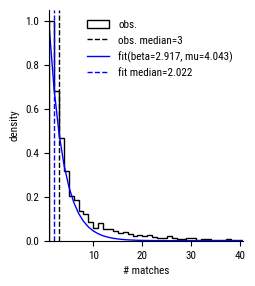

ppm=0.6 tol=0.8


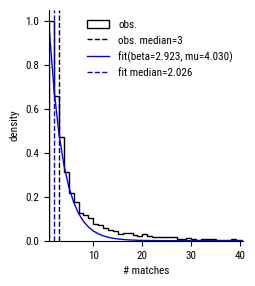

ppm=0.6 tol=0.5


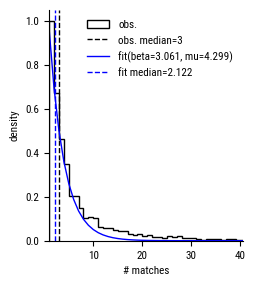

ppm=0.6 tol=0.65


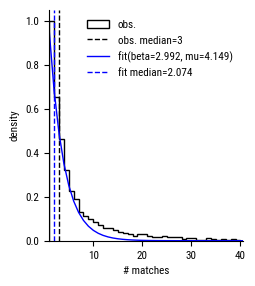

ppm=0.6 tol=0.25


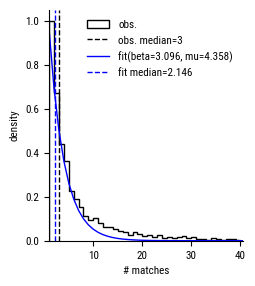

ppm=0.6 tol=0.1


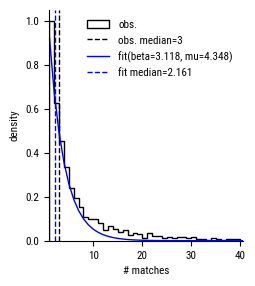

ppm=1.0 tol=0.99


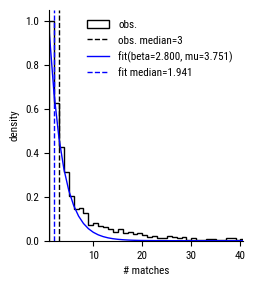

ppm=1.0 tol=0.95


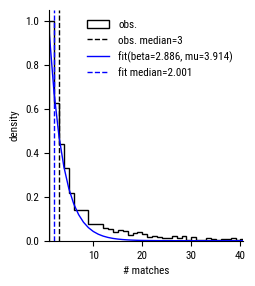

ppm=1.0 tol=0.9


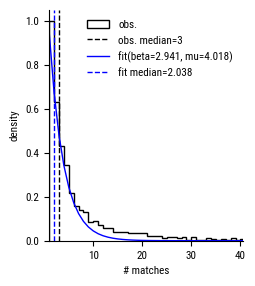

ppm=1.0 tol=0.8


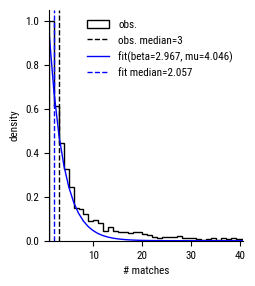

ppm=1.0 tol=0.5


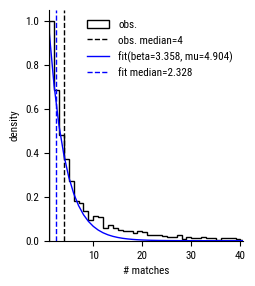

ppm=1.0 tol=0.65


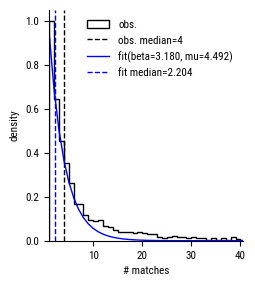

ppm=1.0 tol=0.25


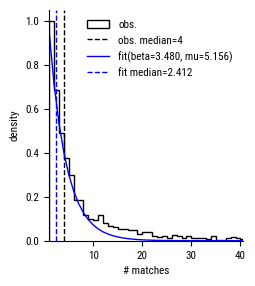

ppm=1.0 tol=0.1


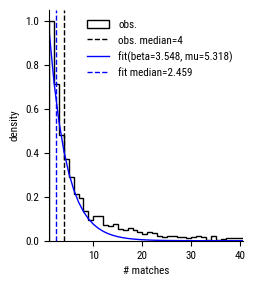

ppm=1.8 tol=0.99


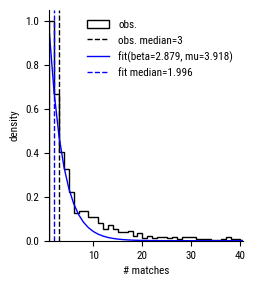

ppm=1.8 tol=0.95


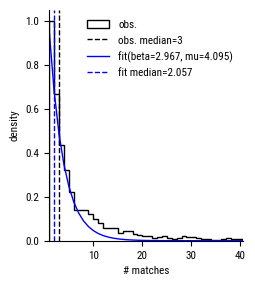

ppm=1.8 tol=0.9


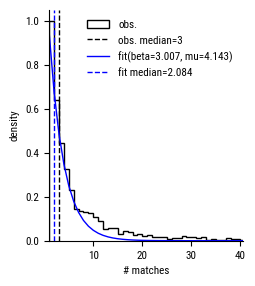

ppm=1.8 tol=0.8


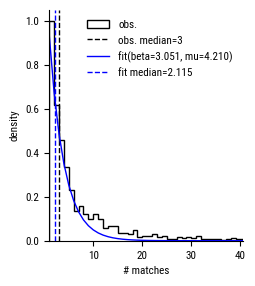

ppm=1.8 tol=0.5


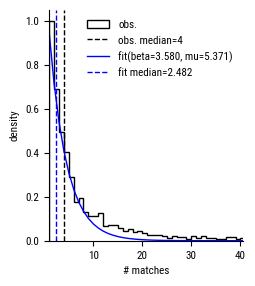

ppm=1.8 tol=0.65


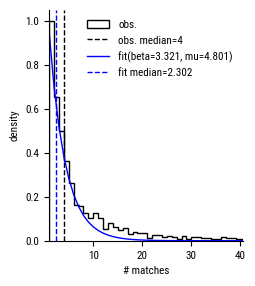

ppm=1.8 tol=0.25


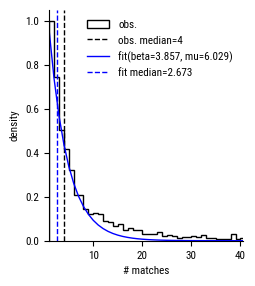

ppm=1.8 tol=0.1


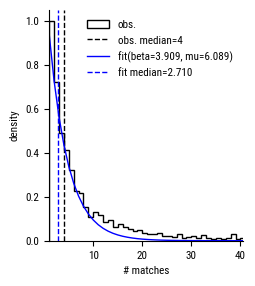

ppm=3.2 tol=0.99


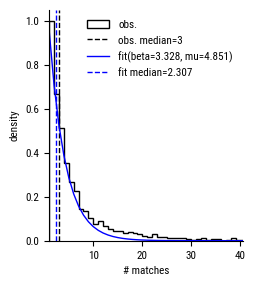

ppm=3.2 tol=0.95


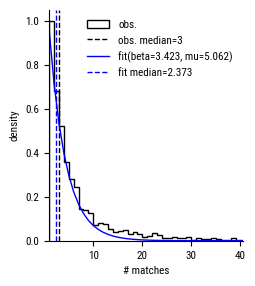

ppm=3.2 tol=0.9


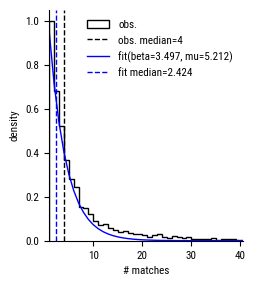

ppm=3.2 tol=0.8


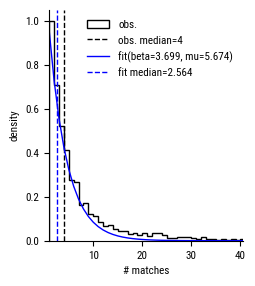

ppm=3.2 tol=0.5


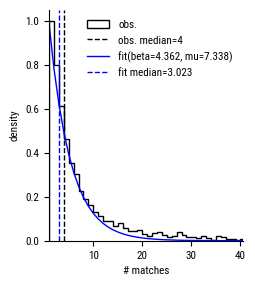

ppm=3.2 tol=0.65


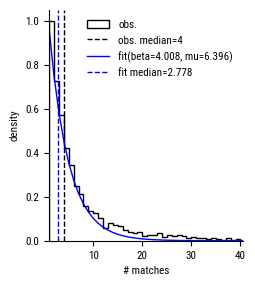

ppm=3.2 tol=0.25


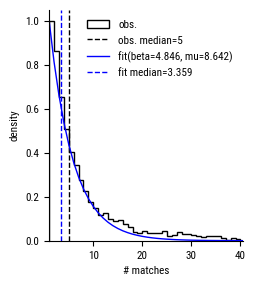

ppm=3.2 tol=0.1


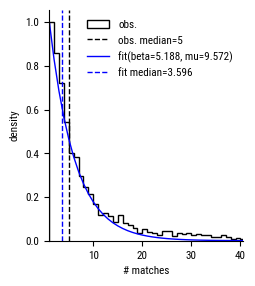

ppm=5.6 tol=0.99


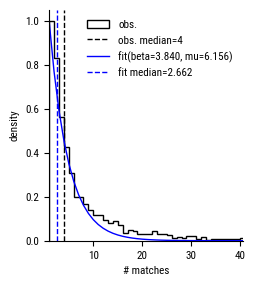

ppm=5.6 tol=0.95


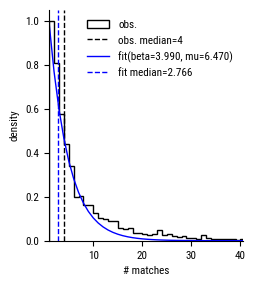

ppm=5.6 tol=0.9


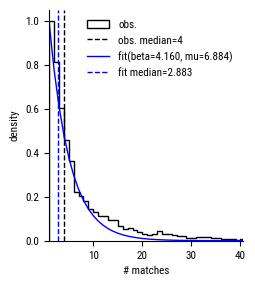

ppm=5.6 tol=0.8


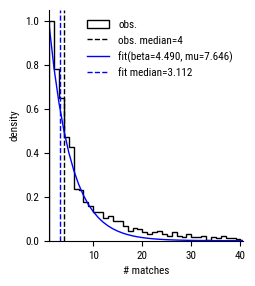

ppm=5.6 tol=0.5


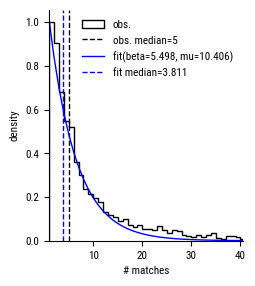

ppm=5.6 tol=0.65


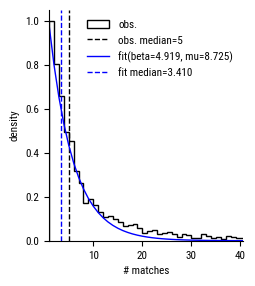

ppm=5.6 tol=0.25


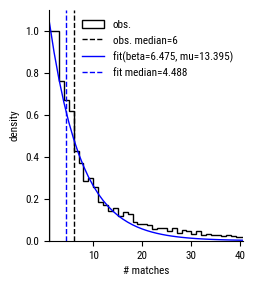

ppm=5.6 tol=0.1


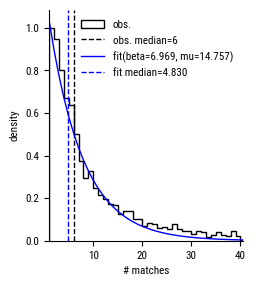

ppm=10.0 tol=0.99


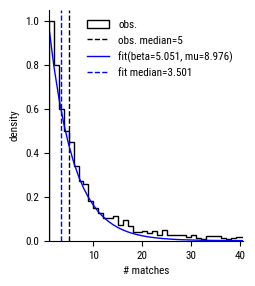

ppm=10.0 tol=0.95


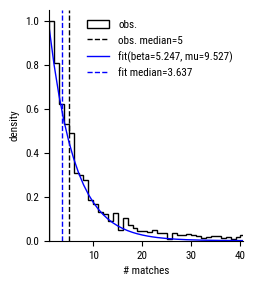

ppm=10.0 tol=0.9


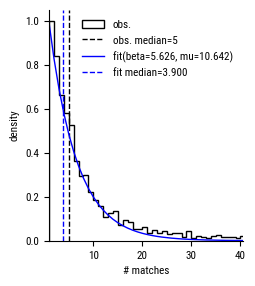

ppm=10.0 tol=0.8


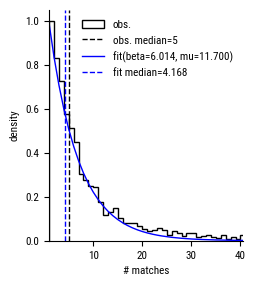

ppm=10.0 tol=0.5


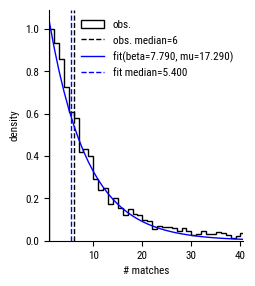

ppm=10.0 tol=0.65


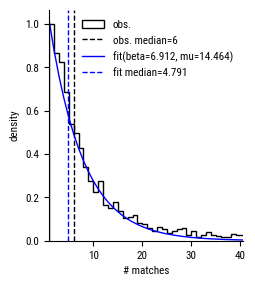

ppm=10.0 tol=0.25


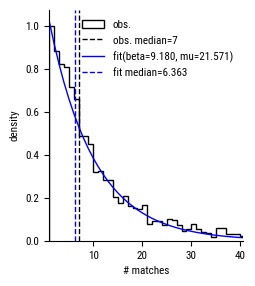

ppm=10.0 tol=0.1


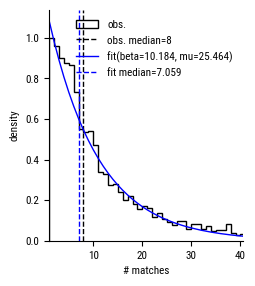

ppm=17.8 tol=0.99


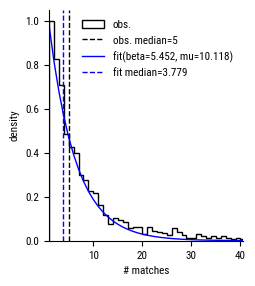

ppm=17.8 tol=0.95


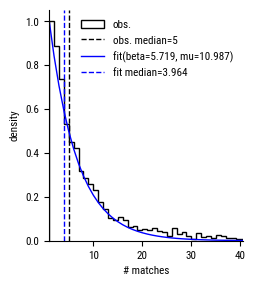

ppm=17.8 tol=0.9


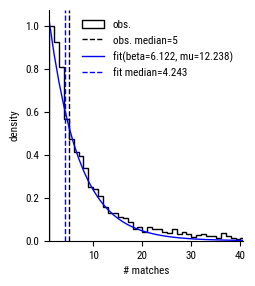

ppm=17.8 tol=0.8


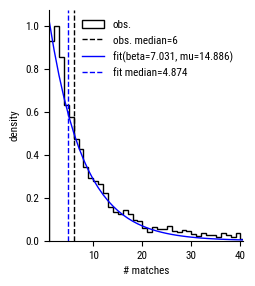

ppm=17.8 tol=0.5


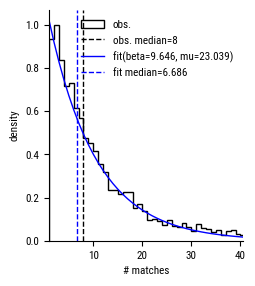

ppm=17.8 tol=0.65


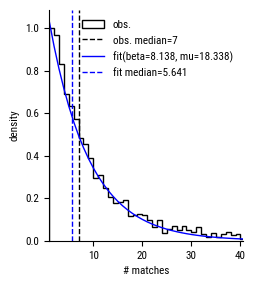

ppm=17.8 tol=0.25


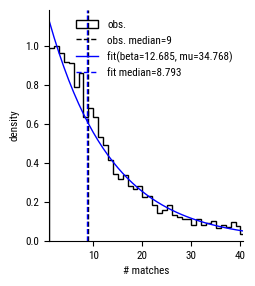

ppm=17.8 tol=0.1


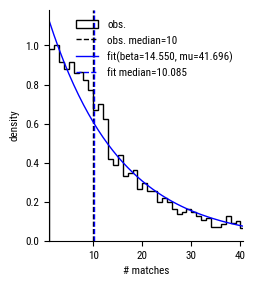

ppm=31.6 tol=0.99


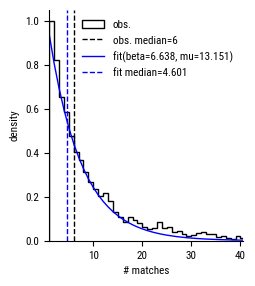

ppm=31.6 tol=0.95


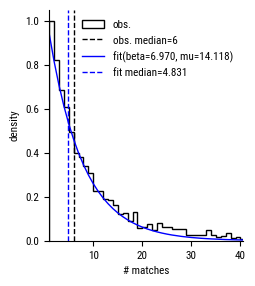

ppm=31.6 tol=0.9


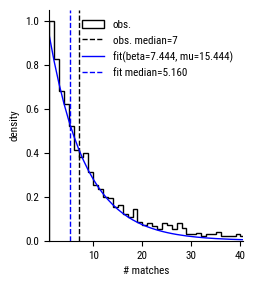

ppm=31.6 tol=0.8


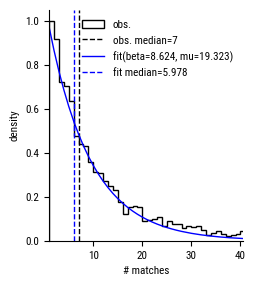

ppm=31.6 tol=0.5


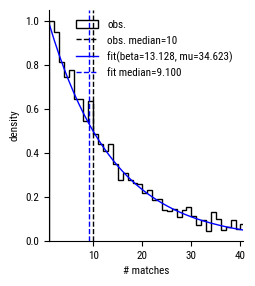

ppm=31.6 tol=0.65


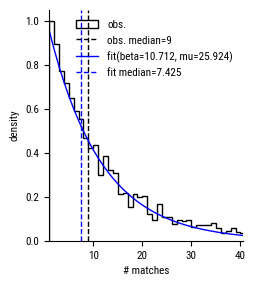

ppm=31.6 tol=0.25


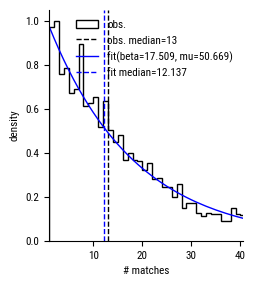

ppm=31.6 tol=0.1


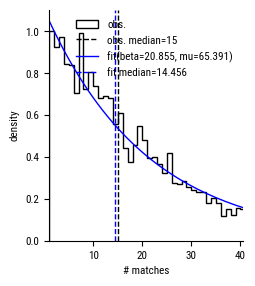

In [51]:
# keep track of fit parameters and summary stats
ppms = []
tols = []
betas = []
mus = []
obs_meds = []
for ppm in MZ_PPMS:
    for tol in MS2_TOLERANCES:
        ppms.append(ppm)
        tols.append(tol)
        print(f"{ppm=} {tol=}")
        fig, ax = plt.subplots(figsize=(2.5, 3))
        bin_max = max(mz_ms2["mz_ms2_probs"][(ppm, tol)]) + 2
        c, x = np.histogram(mz_ms2["mz_ms2_probs"][(ppm, tol)], np.arange(1, bin_max))
        cn = c / max(c)
        ax.hist(mz_ms2["mz_ms2_probs"][(ppm, tol)], bins=np.arange(1, bin_max), color="k", histtype="step", lw=1., 
                weights=[1 / max(c)] * len(mz_ms2["mz_ms2_probs"][(ppm, tol)]), label="obs.") 
        obs_med = np.median(mz_ms2["mz_ms2_probs"][(ppm, tol)])
        ax.axvline(obs_med, ls="--", lw=1., label=f"obs. median={obs_med:.0f}", c="k")
        #print(x[:-1])
        #print(cn)
        (beta, mu), _ = optimize.curve_fit(fexp, x[:-1], cn)
        ax.plot(x[:-1], fexp(x[:-1], beta, mu), 'b-', lw=1., label=f"fit({beta=:.3f}, {mu=:.3f})")
        fit_med = beta * np.log(2.)
        ax.axvline(fit_med, ls="--", lw=1., label=f"fit median={fit_med:.3f}", c="b")
        ax.legend(frameon=False)
        for d in ["top", "right"]:
            ax.spines[d].set_visible(False)
        #ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax.set_xlabel("# matches")
        ax.set_ylabel("density")
        ax.set_xlim([1, 40 + 0.5])
        plt.savefig(f"_figures/mz_ms2/{ppm=}_{tol=}_dist_with_fit.png", 
                    dpi=400, bbox_inches="tight")
        plt.show()
        plt.close()
        betas.append(beta)
        mus.append(mu)
        obs_meds.append(obs_med)
fit_meds = [_ * np.log(2) for _ in betas]

In [52]:
min(fit_meds), max(fit_meds)

(1.9107154850871886, 14.455502212249117)

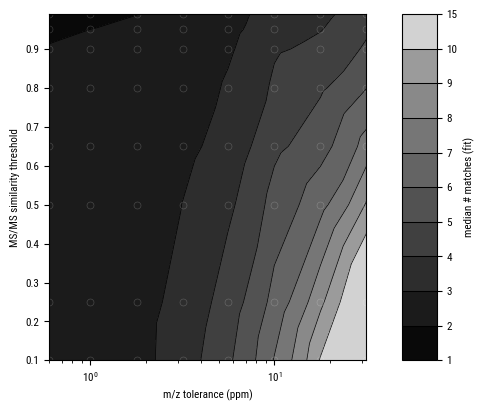

In [53]:
fig, (ax, axcb) = plt.subplots(ncols=2, width_ratios=(9, 1), figsize=(5, 4.5))
mz_bins = MZ_PPMS + [56]
ms2_bins = [1.0] + MS2_TOLERANCES
#levels = [_ for _ in range(2, 27, 2)] #np.arange(2., 26.1, 2.)
levels = [_ + 1 for _ in range(10)] + [15]
tcf = ax.tricontourf(ppms, tols, fit_meds, levels, cmap="binary_r", )#norm="log")
ax.tricontour(ppms, tols, fit_meds, levels, colors="k", linewidths=0.5)
ax.plot(ppms, tols, "wo", ms=5, fillstyle="none", mew=0.5, alpha=0.2)
ax.set_xlabel("m/z tolerance (ppm)")
ax.set_ylabel("MS/MS similarity threshold")
ax.set_xscale("log")
#ax.set_yscale("log")
cb = fig.colorbar(tcf, cax=axcb)
cb.set_ticks(levels)
cb.set_ticklabels(levels)
for l in levels[1:-1]:
    cb.ax.axhline(l, lw=0.75, c="k")
cb.set_label("median # matches (fit)")
plt.savefig(f"_figures/mz_ms2/2D_tolerance_contour.png", 
            dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [30]:
(min(fit_meds), max(fit_meds))

(1.818594566626189, 13.564593048240557)

In [45]:
np.mean([len(mz_ms2["mz_ms2_probs"][(_mzt, _ms2t)]) for _mzt in MZ_PPMS for _ms2t in MS2_TOLERANCES])

1088.828125

In [44]:
mz_ms2.keys()

dict_keys(['mz_ms2_probs', 'mzs'])